In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from scipy import stats
import plotly.express as px

In [2]:
import warnings
import seaborn as sns

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Set a custom color palette
custom_colors = ["#D72638", "#3F88C5", "#140F2D", "#F49D37"]
sns.set_palette(custom_colors)

# Set a base style
sns.set_style("whitegrid")

# Customize specific style parameters
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.color": "#cccccc",
    "axes.facecolor": "#f0f0f0",
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
}
sns.set_context("notebook", rc=custom_params)

In [3]:
df = pd.read_csv('/kaggle/input/data-science-job-posting-on-glassdoor/Uncleaned_DS_jobs.csv')

In [4]:
df.head()

index          Job Title               Salary Estimate  \
0      0  Sr Data Scientist  $137K-$171K (Glassdoor est.)   
1      1     Data Scientist  $137K-$171K (Glassdoor est.)   
2      2     Data Scientist  $137K-$171K (Glassdoor est.)   
3      3     Data Scientist  $137K-$171K (Glassdoor est.)   
4      4     Data Scientist  $137K-$171K (Glassdoor est.)   

                                     Job Description  Rating  \
0  Description\n\nThe Senior Data Scientist is re...     3.1   
1  Secure our Nation, Ignite your Future\n\nJoin ...     4.2   
2  Overview\n\n\nAnalysis Group is one of the lar...     3.8   
3  JOB DESCRIPTION:\n\nDo you have a passion for ...     3.5   
4  Data Scientist\nAffinity Solutions / Marketing...     2.9   

              Company Name       Location            Headquarters  \
0         Healthfirst\n3.1   New York, NY            New York, NY   
1             ManTech\n4.2  Chantilly, VA             Herndon, VA   
2      Analysis Group\n3.8     Boston, MA              Boston, MA   
3             INFICON\n3.5     Newton, MA  Bad Ragaz, Switzerland   
4  Affinity Solutions\n2.9   New York, NY            New York, NY   

                      Size  Founded        Type of ownership  \
0   1001 to 5000 employees     1993   Nonprofit Organization   
1  5001 to 10000 employees     1968         Company - Public   
2   1001 to 5000 employees     1981  Private Practice / Firm   
3    501 to 1000 employees     2000         Company - Public   
4      51 to 200 employees     1998        Company - Private   

                                Industry             Sector  \
0                     Insurance Carriers          Insurance   
1                 Research & Development  Business Services   
2                             Consulting  Business Services   
3  Electrical & Electronic Manufacturing      Manufacturing   
4                Advertising & Marketing  Business Services   

                      Revenue  \
0    Unknown / Non-Applicable   
1      $1 to $2 billion (USD)   
2  $100 to $500 million (USD)   
3  $100 to $500 million (USD)   
4    Unknown / Non-Applicable   

                                         Competitors  
0            EmblemHealth, UnitedHealth Group, Aetna  
1                                                 -1  
2                                                 -1  
3  MKS Instruments, Pfeiffer Vacuum, Agilent Tech...  
4               Commerce Signals, Cardlytics, Yodlee

In [5]:
# Drop the 'index' column from the DataFrame
# inplace=True ensures that the operation is done directly on the original DataFrame, without needing to reassign it.
# axis=1 specifies that we are dropping a column (as opposed to axis=0, which would be used for rows).
df.drop('index', inplace=True, axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job Title          672 non-null    object 
 1   Salary Estimate    672 non-null    object 
 2   Job Description    672 non-null    object 
 3   Rating             672 non-null    float64
 4   Company Name       672 non-null    object 
 5   Location           672 non-null    object 
 6   Headquarters       672 non-null    object 
 7   Size               672 non-null    object 
 8   Founded            672 non-null    int64  
 9   Type of ownership  672 non-null    object 
 10  Industry           672 non-null    object 
 11  Sector             672 non-null    object 
 12  Revenue            672 non-null    object 
 13  Competitors        672 non-null    object 
dtypes: float64(1), int64(1), object(12)
memory usage: 73.6+ KB


# Data Cleaning Part

In [7]:
import re

# My Approach to Extracting Job Description Information

1. **Skills Extraction**:
   - When I looked at the job descriptions, I realized it’s important to know which specific technical skills employers are asking for. So, I wrote a function to pick out key skills like Python, SQL, and Java.

2. **Education Extraction**:
   - I noticed that education levels vary across job listings, so I decided to extract qualifications like Bachelor’s, Master’s, and PhD to get a clearer picture of what’s required for each role.

3. **Experience Extraction**:
   - I saw that years of experience are often mentioned, but in different ways. To standardize this, I created a function to pull out the number of years required, whether it’s written as "3 years" or "5+ years".

4. **Application**:
   - By applying these functions to the job descriptions, I’m transforming unstructured text into organized data. This makes it much easier to analyze trends and requirements across different job listings.

In [8]:
df['Job Description'].iloc[1]

"Secure our Nation, Ignite your Future\n\nJoin the top Information Technology and Analytic professionals in the industry to make invaluable contributions to our national security on a daily basis. In this innovative, self-contained, Big Data environment, the ManTech team is responsible for everything from infrastructure, to application development, to data science, to advanced analytics and beyond. The team is diverse, the questions are thought-provoking, and the opportunities for growth and advancement are numerous\n\nThe successful candidate will possess a diverse range of data-focused skills and experience, both technical and analytical. They will have a strong desire and capability for problem solving, data analysis and troubleshooting, analytical thinking, and experimentation.\n\nDuties, Tasks & Responsibilities\nWorking with large, complex, and disparate data sets\nDesigning and implementing innovative ways to analyze and exploit the Sponsors data holdings\nResearching and report

In [9]:
# Function to extract skills mentioned in the job description
def extract_skills(description):
    # List of skills to look for in the job description
    skills = ['Python', 'R', 'SQL', 'Java', 'C++', 'Scala', 'Julia']
    # Return a list of skills found in the description, case insensitive
    return [skill for skill in skills if skill.lower() in description.lower()]

# Function to extract education levels mentioned in the job description
def extract_education(description):
    # List of educational qualifications to look for
    education_levels = ['Bachelor', 'Master', 'PhD', 'Doctorate']
    # Return a list of education levels found in the description, case insensitive
    return [level for level in education_levels if level.lower() in description.lower()]

# Function to extract years of experience mentioned in the job description
def extract_experience(description):
    # Regular expression to search for years of experience (e.g., "3 years", "5yr")
    experience = re.search(r'(\d+)\+?\s*(?:year|yr)s?', description, re.IGNORECASE)
    # Return the number of years as an integer, or NaN if not found
    return int(experience.group(1)) if experience else np.nan

# Apply the extract functions to the 'Job Description' column and create new columns in the DataFrame
df['Skills'] = df['Job Description'].apply(extract_skills)         # Extract skills
df['Education'] = df['Job Description'].apply(extract_education)   # Extract education levels
df['Years_Experience'] = df['Job Description'].apply(extract_experience)  # Extract years of experience

In [10]:
df['Salary Estimate'].unique()

array(['$137K-$171K (Glassdoor est.)', '$75K-$131K (Glassdoor est.)',
       '$79K-$131K (Glassdoor est.)', '$99K-$132K (Glassdoor est.)',
       '$90K-$109K (Glassdoor est.)', '$101K-$165K (Glassdoor est.)',
       '$56K-$97K (Glassdoor est.)', '$79K-$106K (Glassdoor est.)',
       '$71K-$123K (Glassdoor est.)', '$90K-$124K (Glassdoor est.)',
       '$91K-$150K (Glassdoor est.)', '$141K-$225K (Glassdoor est.)',
       '$145K-$225K(Employer est.)', '$79K-$147K (Glassdoor est.)',
       '$122K-$146K (Glassdoor est.)', '$112K-$116K (Glassdoor est.)',
       '$110K-$163K (Glassdoor est.)', '$124K-$198K (Glassdoor est.)',
       '$79K-$133K (Glassdoor est.)', '$69K-$116K (Glassdoor est.)',
       '$31K-$56K (Glassdoor est.)', '$95K-$119K (Glassdoor est.)',
       '$212K-$331K (Glassdoor est.)', '$66K-$112K (Glassdoor est.)',
       '$128K-$201K (Glassdoor est.)', '$138K-$158K (Glassdoor est.)',
       '$80K-$132K (Glassdoor est.)', '$87K-$141K (Glassdoor est.)',
       '$92K-$155K (Glassdo

# My Approach to Processing Salary Estimates

1. **Initial Cleanup**:
   - I noticed that the 'Salary Estimate' column often includes extra information in parentheses. To simplify it, I split the string at the first '(', keeping only the part before it.

2. **Removing Unwanted Characters**:
   - To focus on the numerical values, I removed the dollar sign ('$') and the letter 'K' (which indicates thousands) from the salary estimates, also trimming any extra spaces.

3. **Splitting Salary into Min and Max**:
   - I split the cleaned salary estimates into two new columns: 'Salary Min' and 'Salary Max' using the '-' delimiter, so I could analyze the range of salaries more effectively.

4. **Type Conversion and Scaling**:
   - I converted these new columns from strings to integers and multiplied by 1000 to represent the full salary amounts.

5. **Calculating Average Salary**:
   - Finally, I calculated the average salary by taking the mean of 'Salary Min' and 'Salary Max', making it easier to assess the typical salary offered.

In [11]:
# Split the 'Salary Estimate' column at the first occurrence of '(', 
# and keep only the part before it (this removes any additional information in parentheses).
df['Salary Estimate'] = df['Salary Estimate'].str.split('(', n=1).str[0]

# Remove the dollar sign ('$') from the salary estimates and strip any leading or trailing whitespace.
df['Salary Estimate'] = df['Salary Estimate'].str.replace('$', '').str.strip()

# Remove the letter 'K' (indicating thousands) and strip any leading or trailing whitespace.
df['Salary Estimate'] = df['Salary Estimate'].str.replace('K', '').str.strip()

# Split the 'Salary Estimate' into two new columns: 'Salary Min' and 'Salary Max' based on the '-' delimiter.
# The expand=True parameter allows the split results to be assigned to multiple columns.
df[['Salary Min', 'Salary Max']] = df['Salary Estimate'].str.split('-', expand=True)

# Convert 'Salary Min' and 'Salary Max' from string to integer types and multiply by 1000
# to reflect the actual salary in full dollars (e.g., 50 becomes 50000).
df['Salary Min'] = df['Salary Min'].astype(int) * 1000
df['Salary Max'] = df['Salary Max'].astype(int) * 1000

# Calculate the average salary by summing 'Salary Min' and 'Salary Max' and performing integer division by 2.
df['avg_salary'] = (df['Salary Min'] + df['Salary Max']) // 2

In [12]:
df[['Company Name']].sample(5)

Company Name
420                                   Robert Half\n3.5
610                        Tygart Technology, Inc\n4.7
331  Blue Cross and Blue Shield of North Carolina\n3.7
211                            Maxar Technologies\n3.5
230                                       Encode, Inc.

In [13]:
# Extract the first line from the 'Company Name' column, 
# assuming that the company name may be split across multiple lines.
# The split is done using the newline character ('\n') as the delimiter.
# str[0] selects the first element from the resulting list after the split.
df['Company Name'] = df['Company Name'].str.split('\n').str[0]

In [14]:
df[['Location']].sample(5)

Location
543  Silver Spring, MD
119       Bethesda, MD
618     Alexandria, VA
248  San Francisco, CA
642    Kansas City, MO

In [15]:
# Process 'Location' column to extract state and city information

# Extract the state from the 'Location' column by splitting the string at ', ' 
# and selecting the last element, which is assumed to be the state.
df['State'] = df['Location'].str.split(', ').str[-1]

# Extract the city from the 'Location' column by splitting the string at ', ' 
# and selecting the first element, which is assumed to be the city.
df['City'] = df['Location'].str.split(', ').str[0]

In [16]:
df[['Size']].sample(5)

Size
603        1 to 50 employees
54       51 to 200 employees
559    501 to 1000 employees
178   1001 to 5000 employees
582  5001 to 10000 employees

# My Approach to Standardizing Company Sizes

1. **Handling Missing or Invalid Values**:
   - I started by checking for any missing values or invalid inputs (like '-1'). If I found any, I returned `NaN` to keep the data clean.

2. **Processing Size Ranges**:
   - For sizes that indicate a range with a '+', such as '10000+', I converted them to a format like '10000-inf' to signify an unknown upper limit.

3. **Formatting Ranges**:
   - I also encountered sizes formatted as '51 to 200 employees.' I standardized these to a more uniform '51-200' format for easier comparison.

4. **Default Case**:
   - If a size didn’t match any of these patterns, I left it unchanged to preserve any valid entries.

5. **Applying the Function**:
   - Finally, I applied this function to the 'Size' column in the DataFrame, ensuring all company sizes are consistent and easy to analyze.


In [17]:
# Function to standardize the 'Size' column in the DataFrame
def standardize_size(size):
    # Handle missing values or specific invalid input ('-1')
    if pd.isna(size) or size == '-1':  
        return np.nan  # Return NaN for missing or invalid sizes

    # Handle sizes with '+' indicating a range like '10000+ employees'
    if '+' in size:  
        return f"{size.split()[0]}+"  # Convert to '10000+' format

    # Handle size ranges formatted as '51 to 200 employees'
    if 'to' in size:  
        return f"{size.split()[0]}-{size.split()[2]}"  # Convert to '51-200'

    # If the size does not match any special case, return it as is
    return size

# Apply the standardize_size function to the 'Size' column in the DataFrame
df['Size'] = df['Size'].apply(standardize_size)

In [18]:
df[['Founded']].sample(5)

Founded
39      1966
427     2012
466     1989
579       -1
642     1992

In [19]:
# Handle 'Founded' column to calculate the age of companies
current_year = 2024  # Define the current year

# Calculate the age of each company by subtracting the 'Founded' year from the current year
df['Age'] = current_year - df['Founded']

# Replace any instance of 'Age' that equals current_year + 1 with NaN
# This handles cases where the 'Founded' year might be future-dated
df['Age'] = df['Age'].replace(current_year + 1, np.nan)

In [20]:
df[['Type of ownership']].sample(5)

Type of ownership
52                Company - Private
204                Company - Public
343               Company - Private
348               Company - Private
164  Subsidiary or Business Segment

In [21]:
# Clean the 'Type of ownership' column by removing the prefix 'Company - '
df['Type of ownership'] = df['Type of ownership'].str.replace('Company - ', '')

In [22]:
# Standardize 'Industry' and 'Sector' columns
df['Industry'] = df['Industry'].str.title()
df['Sector'] = df['Sector'].str.title()

In [23]:
df[['Revenue']].sample(5)

Revenue
91     $5 to $10 million (USD)
43    Unknown / Non-Applicable
448    $5 to $10 billion (USD)
228  $50 to $100 million (USD)
34   $50 to $100 million (USD)

# My Approach to Cleaning Revenue Data

1. **Handling Missing or Invalid Values**:
   - I started by checking for any missing values or invalid entries (like '-1'). If I found any, I returned `NaN` to ensure the dataset remains clean.

2. **Extracting Numerical Values**:
   - I used a regular expression to find all numerical values in the revenue string, as revenue can come in various formats.

3. **Identifying Units**:
   - I checked if the revenue mentioned 'million' or 'billion' to understand the scale. If it’s 'million', I multiplied the numbers by 1,000,000; if it’s 'billion', I multiplied by 1,000,000,000.

4. **Calculating Averages for Ranges**:
   - If I found two numbers (indicating a revenue range), I calculated the average. If only one number was found, I returned that value directly.

5. **Applying the Function**:
   - Finally, I applied this function to the 'Revenue' column, creating a new column called 'AverageRevenue' that standardizes revenue values for easier analysis.

In [24]:
# Function to clean and standardize revenue values
def clean_revenue(revenue):
    # Check for missing values or invalid revenue indicators
    if pd.isna(revenue) or revenue == '-1':
        return np.nan  # Return NaN for missing or invalid values
    
    # Find all numerical values in the revenue string
    numbers = re.findall(r'\d+', revenue)
    
    # Check if 'million' is mentioned in the revenue string
    if 'million' in revenue.lower():
        # Convert each found number to millions
        bounds = [float(num) * 1e6 for num in numbers]
    # Check if 'billion' is mentioned in the revenue string
    elif 'billion' in revenue.lower():
        # Convert each found number to billions
        bounds = [float(num) * 1e9 for num in numbers]
    else:
        return np.nan  # Return NaN if neither 'million' nor 'billion' is found
    
    # If there are two numbers (indicating a revenue range), calculate the average
    if len(bounds) == 2:
        return np.mean(bounds)  # Return the average of the two bounds
    elif len(bounds) == 1:
        return bounds[0]  # If only one number is found, return it as the revenue
    
    return np.nan  # Return NaN if no valid numbers are found

# Apply the clean_revenue function to the 'Revenue' column and create a new column 'AverageRevenue'
df['AverageRevenue'] = df['Revenue'].apply(clean_revenue)

In [25]:
df[['AverageRevenue']].sample(5)

AverageRevenue
50     1.750000e+07
271    3.000000e+08
629    1.750000e+07
33     1.500000e+09
453    3.750000e+07

In [26]:
df[['Competitors']].sample(5)

Competitors
558  KPMG, Accenture, Deloitte
240                         -1
325                         -1
457                         -1
42                          -1

In [27]:
# Fill missing values in the 'Competitors' column with an empty string
df['Competitors'] = df['Competitors'].fillna('')

# Create a new column 'Number_of_Competitors' to count the number of competitors
# Split the 'Competitors' string by commas and count the resulting items
df['Number_of_Competitors'] = df['Competitors'].apply(lambda x: len(x.split(',')) if x else 0)

In [28]:
df = df.replace('Unknown', np.nan)

In [29]:
df[['Job Title']].sample(5)

Job Title
548  Data Engineer (Analytics, SQL, Python, AWS)
499                               Data Scientist
24                                Data Scientist
257           Computational Behavioral Scientist
535        Machine Learning Scientist / Engineer

In [30]:
# Function to determine the experience level based on the job title
def get_experience_level(title):
    # Check if the title contains 'senior' or 'lead', indicating a senior position
    if 'senior' in title.lower() or 'lead' in title.lower():
        return 'Senior'  # Return 'Senior' if applicable
    # Check if the title contains 'junior', indicating a junior position
    elif 'junior' in title.lower():
        return 'Junior'  # Return 'Junior' if applicable
    else:
        return 'Mid-level'  # Return 'Mid-level' for all other cases

# Apply the get_experience_level function to the 'Job Title' column 
# and create a new column 'Experience_Level' in the DataFrame
df['Experience_Level'] = df['Job Title'].apply(get_experience_level)

In [31]:
# Convert the 'Rating' column to float data type for numerical analysis
df['Rating'] = df['Rating'].astype('float')

# Convert the 'Founded' column to integer data type to represent the founding year
df['Founded'] = df['Founded'].astype('int')

# List of categorical columns to convert
categorical_columns = ['Job Title', 'Company Name', 'Location', 'Type of ownership', 'Industry', 'Sector']

# Loop through each categorical column and convert its data type to 'category'
for col in categorical_columns:
    df[col] = df[col].astype('category')  # Convert to categorical type for memory efficiency and analysis

In [32]:
df.drop(['Job Description', 'Location', 'Headquarters', 'Revenue','Competitors'], axis=1, inplace=True)

In [33]:
# Function to simplify job titles into standardized categories
def title_simplifier(title):
    # Convert the title to lowercase for consistent matching
    title = title.lower()

    # Define a mapping of job title keywords to simplified titles
    title_mappings = {
        'data scientist': 'data scientist',  # Maps 'data scientist' to itself
        'data engineer': 'data engineer',    # Maps 'data engineer' to itself
        'analyst': 'analyst',                # Maps 'analyst' to itself
        'machine learning': 'mle',           # Maps 'machine learning' to 'mle' (Machine Learning Engineer)
        'manager': 'manager',                # Maps 'manager' to itself
        'director': 'director',              # Maps 'director' to itself
    }

    # Iterate through the title mappings to find a match
    for key, simplified_title in title_mappings.items():
        if key in title:  # Check if the keyword is in the title
            return simplified_title  # Return the corresponding simplified title

    return 'Other'  # Return 'Other' if no match is found

In [34]:
df['Job Title'] = df['Job Title'].apply(title_simplifier)

In [35]:
# Define bins and corresponding label
labels = ['Low', 'Medium', 'High', 'Very High']    # 4 labels

# Use pd.cut to categorize the AverageSalary
df['SalaryCategory'] = pd.cut(df['avg_salary'], bins=4, labels=labels, right=False)

In [36]:
# Renaming columns in pandas DataFrame
df.rename(columns={
    'Job Title': 'JobTitle',
    'Salary Estimate': 'SalaryEstimate',
    'Rating': 'Rating',
    'Company Name': 'CompanyName',
    'Size': 'CompanySize',
    'Founded': 'FoundedYear',
    'Type of ownership': 'OwnershipType',
    'Industry': 'Industry',
    'Sector': 'Sector',
    'Skills': 'RequiredSkills',
    'Education': 'EducationLevel',
    'Years_Experience': 'YearsExperience',
    'Salary Min': 'SalaryMin',
    'Salary Max': 'SalaryMax',
    'avg_salary': 'AverageSalary',
    'State': 'State',
    'City': 'City',
    'Age': 'CompanyAge',
    'Revenue_Lower_Bound': 'RevenueLowerBound',
    'Number_of_Competitors': 'NumberOfCompetitors',
    'Experience_Level': 'ExperienceLevel'
}, inplace=True)

In [37]:
df.sample(10)

JobTitle SalaryEstimate  Rating         CompanyName CompanySize  \
102  data scientist         99-132     4.1           Evidation      51-200   
642   data engineer         92-155     3.3        Americo Life     201-500   
29   data scientist        137-171     2.8           Formation      51-200   
103  data scientist         99-132     4.0            Autodesk  5001-10000   
132   data engineer         90-109     4.4       Direct Agents      51-200   
643  data scientist         92-155     3.3    Tokio Marine HCC   1001-5000   
89   data scientist         79-131     3.9                Mars     10000++   
204  data scientist         79-106     3.9            Novartis     10000++   
512  data scientist        212-331     3.5  Maxar Technologies  5001-10000   
286  data scientist        141-225     4.0         AstraZeneca     10000++   

     FoundedYear OwnershipType                                 Industry  \
102         2012       Private                                 Internet   
642         1992       Private                       Insurance Carriers   
29          2015       Private  Enterprise Software & Network Solutions   
103         1982        Public             Computer Hardware & Software   
132         2003       Private                  Advertising & Marketing   
643         1974       Private                       Insurance Carriers   
89          1911       Private            Food & Beverage Manufacturing   
204         1996        Public                Biotech & Pharmaceuticals   
512           -1        Public                      Aerospace & Defense   
286         1913        Public                Biotech & Pharmaceuticals   

                        Sector                 RequiredSkills  ... SalaryMin  \
102     Information Technology                    [Python, R]  ...     99000   
642                  Insurance  [Python, R, SQL, Java, Scala]  ...     92000   
29      Information Technology                     [R, Scala]  ...    137000   
103     Information Technology  [Python, R, SQL, Java, Scala]  ...     99000   
132          Business Services               [Python, R, SQL]  ...     90000   
643                  Insurance                    [Python, R]  ...     92000   
89               Manufacturing                    [Python, R]  ...     79000   
204  Biotech & Pharmaceuticals                            [R]  ...     79000   
512        Aerospace & Defense    [Python, R, SQL, Java, C++]  ...    212000   
286  Biotech & Pharmaceuticals             [Python, R, Scala]  ...    141000   

     SalaryMax  AverageSalary          State           City CompanyAge  \
102     132000         115500             CA  Santa Barbara       12.0   
642     155000         123500             MO    Kansas City       32.0   
29      171000         154000             CA  San Francisco        9.0   
103     132000         115500             CA  San Francisco       42.0   
132     109000          99500             CA    Culver City       21.0   
643     155000         123500             TX        Houston       50.0   
89      131000         105000  United States  United States      113.0   
204     106000          92500             MA      Cambridge       28.0   
512     331000         271500             VA        Herndon        NaN   
286     225000         183000             NY       New York      111.0   

    AverageRevenue  NumberOfCompetitors  ExperienceLevel  SalaryCategory  
102            NaN                    1        Mid-level          Medium  
642   3.000000e+08                    1        Mid-level          Medium  
29             NaN                    1        Mid-level          Medium  
103   3.500000e+09                    1           Senior          Medium  
132   3.750000e+07                    1        Mid-level             Low  
643            NaN                    3        Mid-level          Medium  
89    1.000000e+10                    1        Mid-level          Medium  
204   1.000000e+10            

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   JobTitle             672 non-null    object  
 1   SalaryEstimate       672 non-null    object  
 2   Rating               672 non-null    float64 
 3   CompanyName          672 non-null    category
 4   CompanySize          628 non-null    object  
 5   FoundedYear          672 non-null    int64   
 6   OwnershipType        668 non-null    category
 7   Industry             672 non-null    category
 8   Sector               672 non-null    category
 9   RequiredSkills       672 non-null    object  
 10  EducationLevel       672 non-null    object  
 11  YearsExperience      444 non-null    float64 
 12  SalaryMin            672 non-null    int64   
 13  SalaryMax            672 non-null    int64   
 14  AverageSalary        672 non-null    int64   
 15  State                67

# Handling Missing Values

In [39]:
# Replace all occurrences of -1 with NaN
df.replace(-1, np.nan, inplace=True)

# Identify columns with NaN values
columns_with_nan = df.columns[df.isna().any()].tolist()

print("Columns with -1 or NaN values:", columns_with_nan)

Columns with -1 or NaN values: ['Rating', 'CompanySize', 'FoundedYear', 'OwnershipType', 'YearsExperience', 'CompanyAge', 'AverageRevenue']


In [40]:
df.isnull().sum()

# Identifying columns with missing values and their count
missing_values = df.isnull().sum()

# Filtering only columns that have missing values
columns_with_missing = missing_values[missing_values > 0]

# Displaying columns with missing values and their respective count
print(columns_with_missing)

Rating              50
CompanySize         44
FoundedYear        118
OwnershipType        4
YearsExperience    228
CompanyAge         118
AverageRevenue     240
dtype: int64


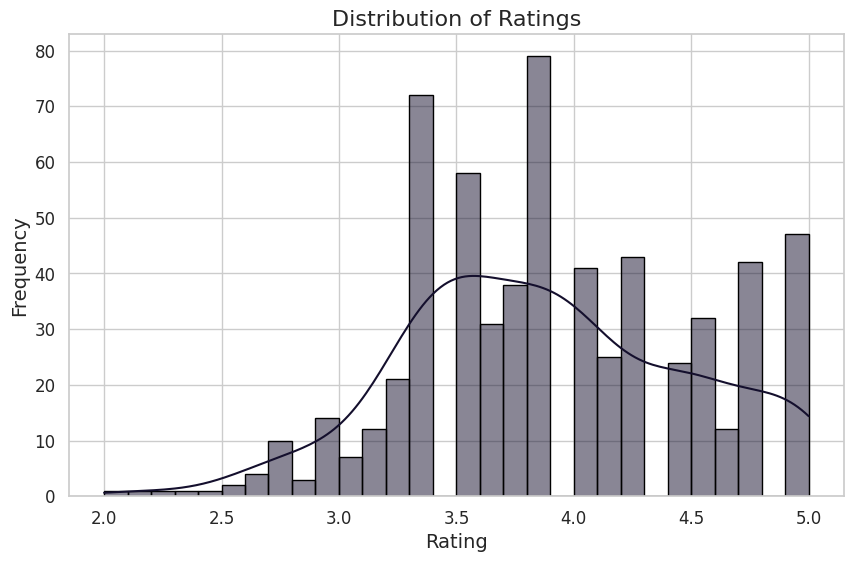

In [41]:
# See the rating column histplot, Is it skewed
plt.figure(figsize=(10, 6))
sns.histplot(x='Rating', data=df, bins=30, kde=True, edgecolor='black', color=custom_colors[2])

# Add titles and labels
plt.title('Distribution of Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.show()

In [42]:
# The median is more robust to skewness and outliers compared to the mean.
# In right-skewed distributions, the mean can be disproportionately affected by high values,
# which may lead to an inaccurate estimation of the central tendency for imputation.
# By using the median, we ensure that the imputed values are not skewed by extreme ratings, 
# resulting in a more reliable representation of the typical rating in the dataset.
# This approach is particularly useful when we want to maintain the integrity of the data
# and avoid introducing bias due to outliers.
df['Rating'].fillna(df['Rating'].median(), inplace=True)

In [43]:
df['CompanySize'].value_counts()

CompanySize
51-200        135
1001-5000     104
1-50           86
201-500        85
10000++        80
501-1000       77
5001-10000     61
Name: count, dtype: int64

In [44]:
df['CompanySize'].fillna('Unknown', inplace=True)

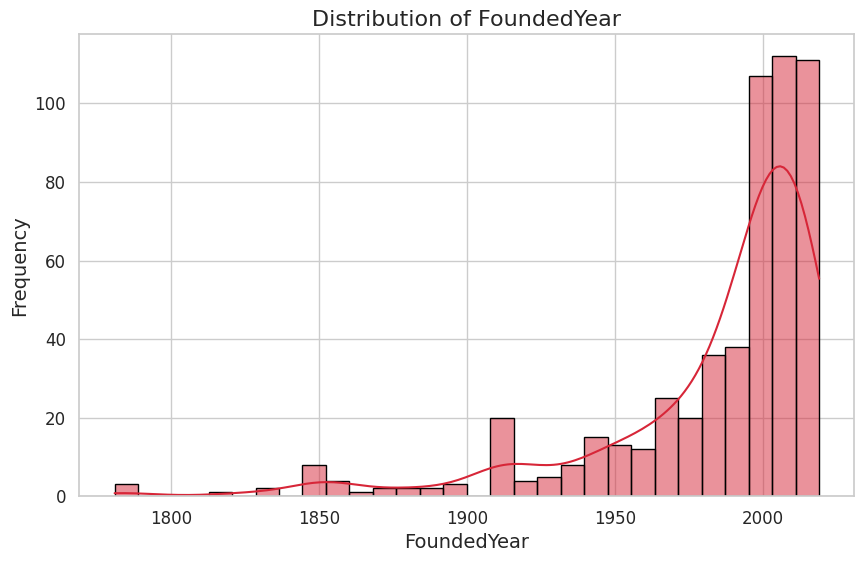

In [45]:
# See the FoundedYear column histplot, Is it skewed
plt.figure(figsize=(10, 6))
sns.histplot(x='FoundedYear', data=df, bins=30, kde=True, color=custom_colors[0], edgecolor='black')

# Add titles and labels
plt.title('Distribution of FoundedYear', fontsize=16)
plt.xlabel('FoundedYear', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.show()

In [46]:
# The median is chosen for imputing missing values in 'FoundedYear' because it is less affected by outliers 
# and provides a more accurate central tendency measure for skewed data. 
# In cases where the data may include extreme values (e.g., very recent or very old companies),
# the mean can be skewed, potentially leading to misleading imputed values. 
# By filling missing values with the median, we preserve the overall distribution of the data 
# and reduce the risk of introducing bias. 
# This ensures that the imputed 'FoundedYear' reflects a more typical founding year for companies 
# in the dataset.
df['FoundedYear'].fillna(df['FoundedYear'].median(), inplace=True)

In [47]:
# Drop rows with missing values in the OwnershipType column
df.dropna(subset=['OwnershipType'], inplace=True)

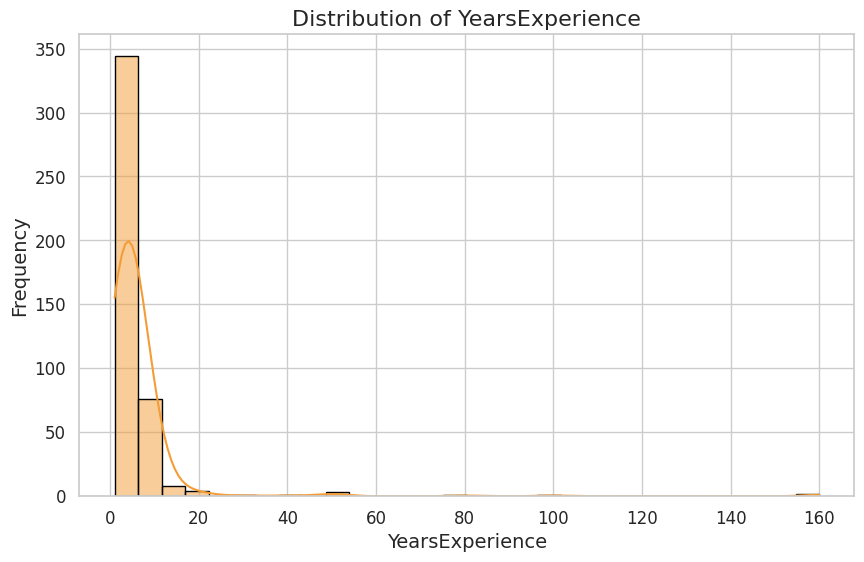

In [48]:
# See the YearsExperience column histplot, Is it skewed
plt.figure(figsize=(10, 6))
sns.histplot(x='YearsExperience', data=df, bins=30, kde=True, color=custom_colors[3], edgecolor='black')

# Add titles and labels
plt.title('Distribution of YearsExperience', fontsize=16)
plt.xlabel('YearsExperience', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.show()

In [49]:
# KNN imputation is utilized for filling missing values in 'YearsExperience' and 'AverageRevenue' 
# due to its ability to capture the underlying structure of the data based on the proximity of observations.
# In left-skewed distributions, the data may have a significant number of lower values, 
# making it important to consider the relationships among different data points.
# KNN leverages the values of the nearest neighbors (in this case, the 5 closest data points)
# to estimate missing values, allowing for a more nuanced and context-aware imputation.
# This method can help maintain the distribution characteristics of both 'YearsExperience' 
# and 'AverageRevenue', resulting in more accurate and reliable filled values compared to simpler methods like mean or median.
knn_imputer = KNNImputer(n_neighbors=5)
df[['YearsExperience', 'AverageRevenue']] = knn_imputer.fit_transform(df[['YearsExperience', 'AverageRevenue']])

In [50]:
# To calculate 'CompanyAge', we subtract the 'FoundedYear' from the current year (2024 in this case).
# This method directly derives the age of the company based on when it was founded.
# By filling missing values in 'CompanyAge' using this approach, we ensure that all records
# have a consistent and accurate age calculation.
# The inplace=True argument ensures that the DataFrame is updated in place, without the need for reassignment.
df['CompanyAge'].fillna(2024 - df['FoundedYear'], inplace=True)

In [51]:
df['OwnershipType'].replace('-1', df['OwnershipType'].mode()[0], inplace=True)
df['Sector'].replace('-1', df['Sector'].mode()[0], inplace=True)

In [52]:
# Replace '-1' in 'Industry' using loc
df.loc[df['Industry'] == '-1', 'Industry'] = np.nan
df['Industry'].fillna(df['Industry'].mode()[0], inplace=True)

In [53]:
df.isnull().sum()

JobTitle               0
SalaryEstimate         0
Rating                 0
CompanyName            0
CompanySize            0
FoundedYear            0
OwnershipType          0
Industry               0
Sector                 0
RequiredSkills         0
EducationLevel         0
YearsExperience        0
SalaryMin              0
SalaryMax              0
AverageSalary          0
State                  0
City                   0
CompanyAge             0
AverageRevenue         0
NumberOfCompetitors    0
ExperienceLevel        0
SalaryCategory         0
dtype: int64

In [54]:
df.describe()

Rating  FoundedYear  YearsExperience      SalaryMin      SalaryMax  \
count  668.000000   668.000000       668.000000     668.000000     668.000000   
mean     3.874401  1986.646707         6.101598   99190.119760  148125.748503   
std      0.588129    37.439179        10.660060   33091.369914   48117.195714   
min      2.000000  1781.000000         1.000000   31000.000000   56000.000000   
25%      3.500000  1983.000000         3.000000   79000.000000  119000.000000   
50%      3.800000  1999.000000         5.000000   91000.000000  133000.000000   
75%      4.300000  2009.000000         6.256236  122000.000000  165000.000000   
max      5.000000  2019.000000       160.000000  212000.000000  331000.000000   

       AverageSalary  CompanyAge  AverageRevenue  NumberOfCompetitors  
count     668.000000  668.000000    6.680000e+02           668.000000  
mean   123657.934132   37.353293    2.518344e+09             1.449102  
std     39661.944569   37.439179    2.976148e+09             0.807823  
min     43500.000000    5.000000    1.000000e+06             1.000000  
25%    103000.000000   15.000000    2.066250e+08             1.000000  
50%    114000.000000   25.000000    2.060000e+09             1.000000  
75%    136500.000000   41.000000    3.500000e+09             1.000000  
max    271500.000000  243.000000    1.000000e+10             3.000000

In [55]:
df.sample(5)

JobTitle SalaryEstimate  Rating     CompanyName CompanySize  \
254  data scientist         90-124     3.3     Insider Inc     201-500   
308  data scientist        145-225     5.0  Kollasoft Inc.     Unknown   
469           Other          31-56     3.9      7Park Data      51-200   
145           Other         90-109     3.8         Evidera    501-1000   
173  data scientist        101-165     3.9  Quartet Health     201-500   

     FoundedYear                   OwnershipType  \
254       2007.0                         Private   
308       1999.0                          Public   
469       2012.0                         Private   
145       2013.0  Subsidiary or Business Segment   
173       2014.0                         Private   

                                    Industry                     Sector  \
254                              News Outlet                      Media   
308                Biotech & Pharmaceuticals     Information Technology   
469                   Research & Development          Business Services   
145                Biotech & Pharmaceuticals  Biotech & Pharmaceuticals   
173  Enterprise Software & Network Solutions     Information Technology   

               RequiredSkills  ... SalaryMin  SalaryMax  AverageSalary  State  \
254               [Python, R]  ...     90000     124000         107000     NY   
308  [Python, R, Java, Scala]  ...    145000     225000         185000     NY   
469               [Python, R]  ...     31000      56000          43500     NY   
145                       [R]  ...     90000     109000          99500     MD   
173        [Python, R, Scala]  ...    101000     165000         133000     NY   

         City CompanyAge AverageRevenue  NumberOfCompetitors  ExperienceLevel  \
254  New York       17.0   7.500000e+07                    1        Mid-level   
308  New York       25.0   2.173759e+09                    1        Mid-level   
469  New York       12.0   4.820000e+09                    1        Mid-level   
145  Bethesda       11.0   3.000000e+08                    2        Mid-level   
173  New York       10.0   4.560000e+09                    1           Senior   

     SalaryCategory  
254          Medium  
308            High  
469             Low  
145             Low  
173          Medium  

[5 rows x 22 columns]

# EDA Part

# Job Title Distribution and Salary Analysis 

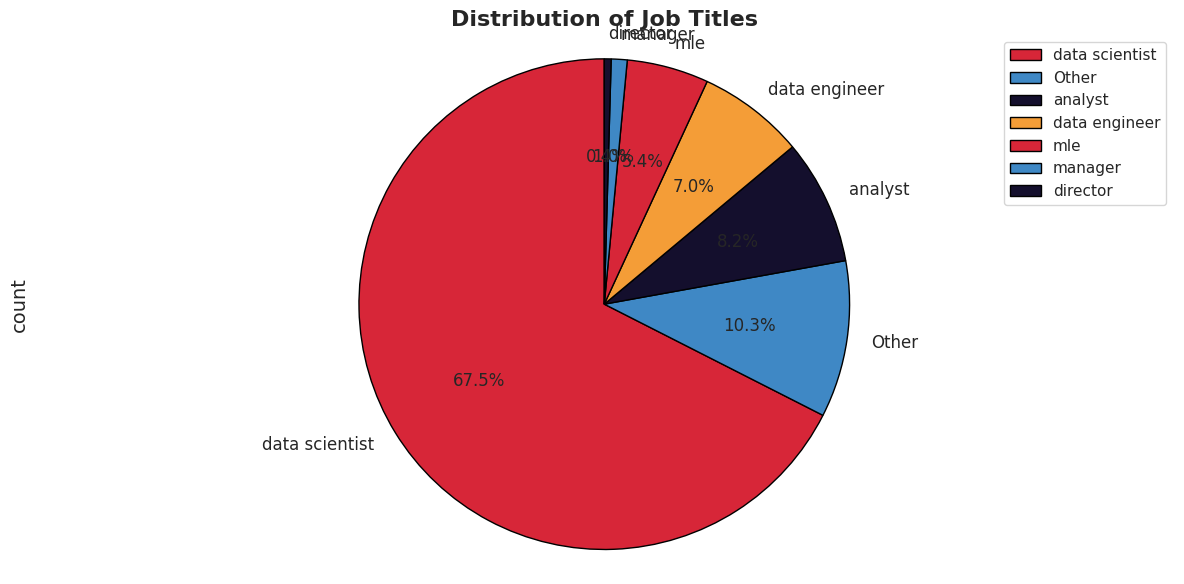

In [56]:
# Job title distribution
plt.figure(figsize=(12, 6))

df['JobTitle'].value_counts().plot(
    kind='pie', 
    autopct='%1.1f%%',   # Display percentage with one decimal
    colors=custom_colors,       # Apply custom color palette
    startangle=90,       # Start the pie chart at 90 degrees for better alignment
    wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'linestyle': 'solid'},  # Add border for better separation
    textprops={'fontsize': 12}  # Adjust font size for readability
)

# Add title and make the pie circular
plt.title('Distribution of Job Titles', fontsize=16, fontweight='bold')
plt.axis('equal')  # Ensures pie chart is a perfect circle

# Remove the legend 
plt.legend(loc='best', bbox_to_anchor=(1, 1))  # Add legend outside the plot if needed

# Display the plot
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

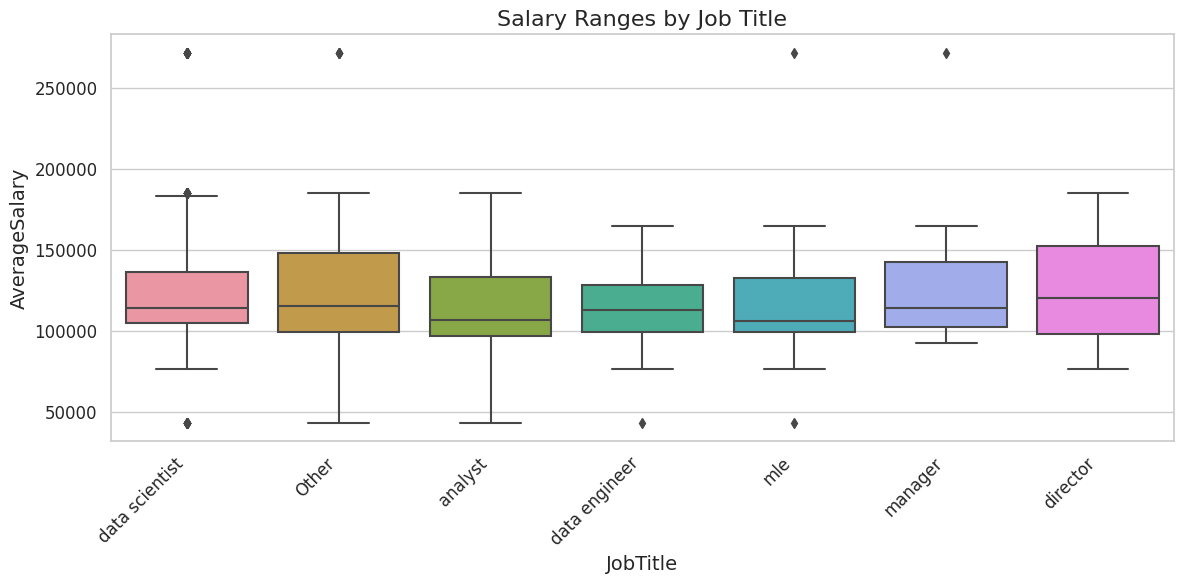

In [57]:
# Salary ranges for each job title
plt.figure(figsize=(12, 6))
sns.boxplot(x='JobTitle', y='AverageSalary', data=df)
plt.xticks(rotation=45, ha='right')
plt.title('Salary Ranges by Job Title')
plt.tight_layout()
plt.show()

In [58]:
# Most common job titles and their median salaries
top_jobs = df['JobTitle'].value_counts().head()
median_salaries = df.groupby('JobTitle')['AverageSalary'].median().loc[top_jobs.index]
print("\nMost common job titles and their median salaries:")
print(pd.concat([top_jobs, median_salaries], axis=1).rename(columns={'JobTitle': 'Count', 'AverageSalary': 'Median Salary'}))


Most common job titles and their median salaries:
                count  Median Salary
JobTitle                            
data scientist    451       114000.0
Other              69       115500.0
analyst            55       107000.0
data engineer      47       113000.0
mle                36       106500.0


# Company Size, Salary, and Rating Analysis

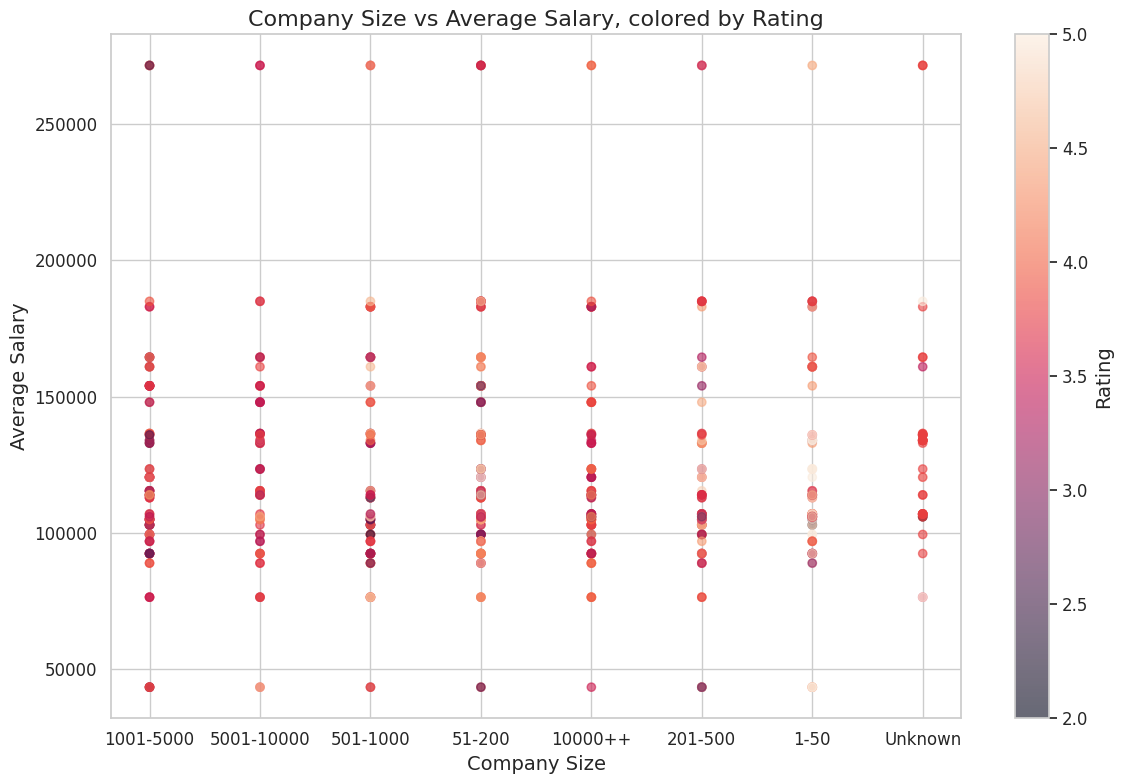

In [59]:
# Scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['CompanySize'], df['AverageSalary'], c=df['Rating'], alpha=0.6)
plt.colorbar(scatter, label='Rating')
plt.xlabel('Company Size')
plt.ylabel('Average Salary')
plt.title('Company Size vs Average Salary, colored by Rating')
plt.tight_layout()
plt.show()

In [60]:
# Correlation coefficients
corr_size_salary = df['CompanySize'].astype('category').cat.codes.corr(df['AverageSalary'])
corr_size_rating = df['CompanySize'].astype('category').cat.codes.corr(df['Rating'])
corr_salary_rating = df['AverageSalary'].corr(df['Rating'])

In [61]:
print("Correlation coefficients:")
print(f"Company Size vs Average Salary: {corr_size_salary:.2f}")
print(f"Company Size vs Rating: {corr_size_rating:.2f}")
print(f"Average Salary vs Rating: {corr_salary_rating:.2f}")

Correlation coefficients:
Company Size vs Average Salary: 0.08
Company Size vs Rating: -0.05
Average Salary vs Rating: -0.00


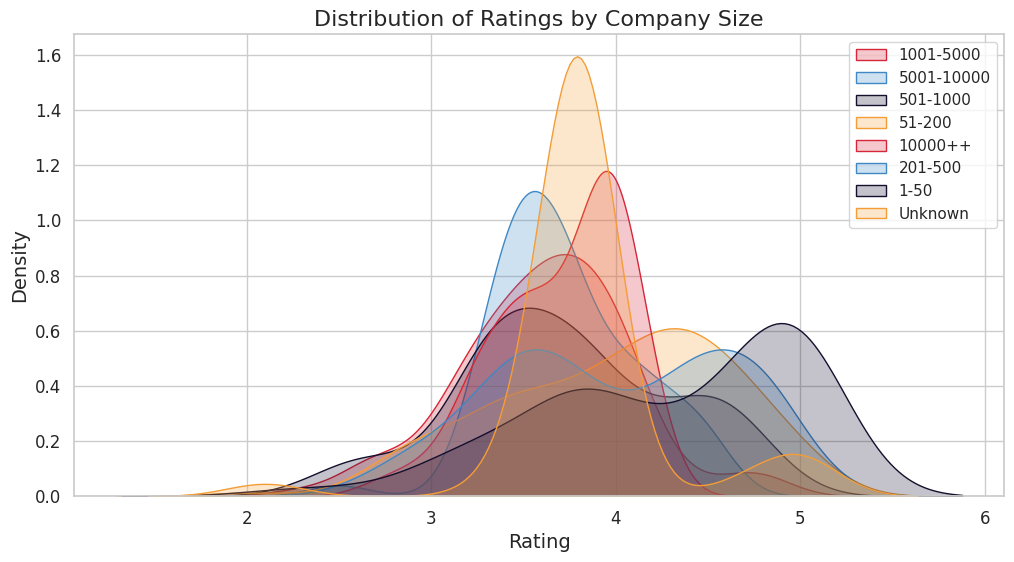

In [62]:
# KDE plot
plt.figure(figsize=(12, 6))
for size in df['CompanySize'].unique():
    sns.kdeplot(df[df['CompanySize'] == size]['Rating'], label=size, shade=True)
plt.xlabel('Rating')
plt.ylabel('Density')
plt.title('Distribution of Ratings by Company Size')
plt.legend()
plt.show()

In [63]:
# Size category with highest average salary and rating
size_stats = df.groupby('CompanySize').agg({
    'AverageSalary': 'mean',
    'Rating': 'mean'
}).sort_values('AverageSalary', ascending=False)

print("\nSize category with highest average salary:")
print(size_stats.head(1))


Size category with highest average salary:
             AverageSalary    Rating
CompanySize                         
Unknown      135738.095238  3.847619


# Salary Distribution by Education and Experience

In [64]:
# Explode the EducationLevel column
df_exploded = df.explode('EducationLevel')

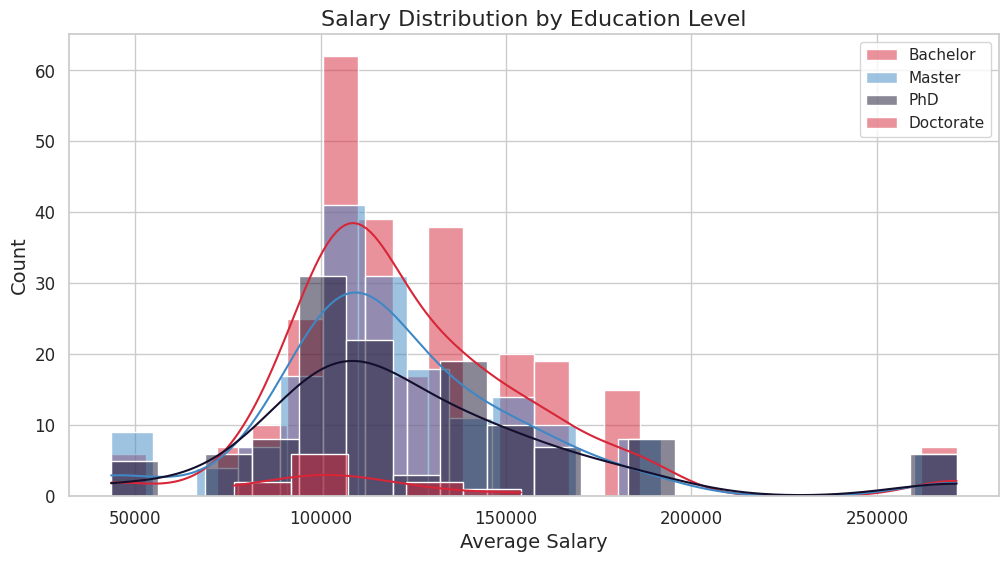

In [65]:
# Overlapping histograms
plt.figure(figsize=(12, 6))
for edu in df_exploded['EducationLevel'].unique():
    sns.histplot(df_exploded[df_exploded['EducationLevel'] == edu]['AverageSalary'], 
                 kde=True, label=edu, alpha=0.5)

plt.xlabel('Average Salary')
plt.ylabel('Count')
plt.title('Salary Distribution by Education Level')
plt.legend()
plt.show()

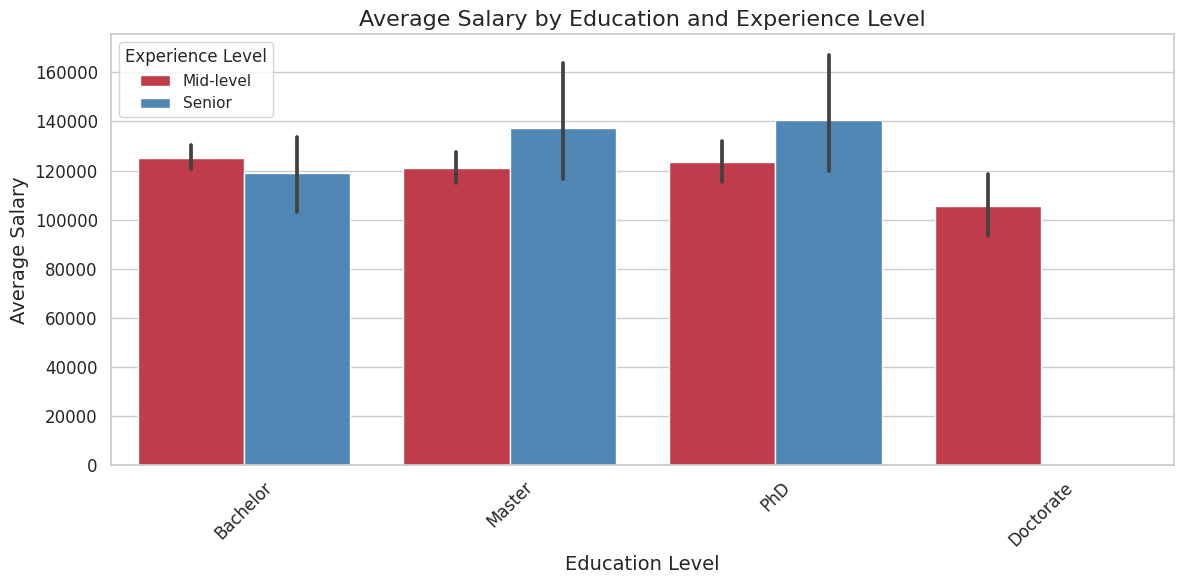

In [66]:
# Grouped bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='EducationLevel', y='AverageSalary', hue='ExperienceLevel', data=df_exploded)
plt.xlabel('Education Level')
plt.ylabel('Average Salary')
plt.title('Average Salary by Education and Experience Level')
plt.xticks(rotation=45)
plt.legend(title='Experience Level')
plt.tight_layout()
plt.show()

In [67]:
# Education-experience combination with highest average salary
highest_combo = df_exploded.groupby(['EducationLevel', 'ExperienceLevel'])['AverageSalary'].mean().idxmax()
highest_salary = df_exploded.groupby(['EducationLevel', 'ExperienceLevel'])['AverageSalary'].mean().max()

print(f"\nHighest average salary combination:")
print(f"Education: {highest_combo[0]}, Experience: {highest_combo[1]}")
print(f"Average Salary: ${highest_salary:.2f}")


Highest average salary combination:
Education: PhD, Experience: Senior
Average Salary: $140789.47


# Salary Trend by Founding Year and Sector

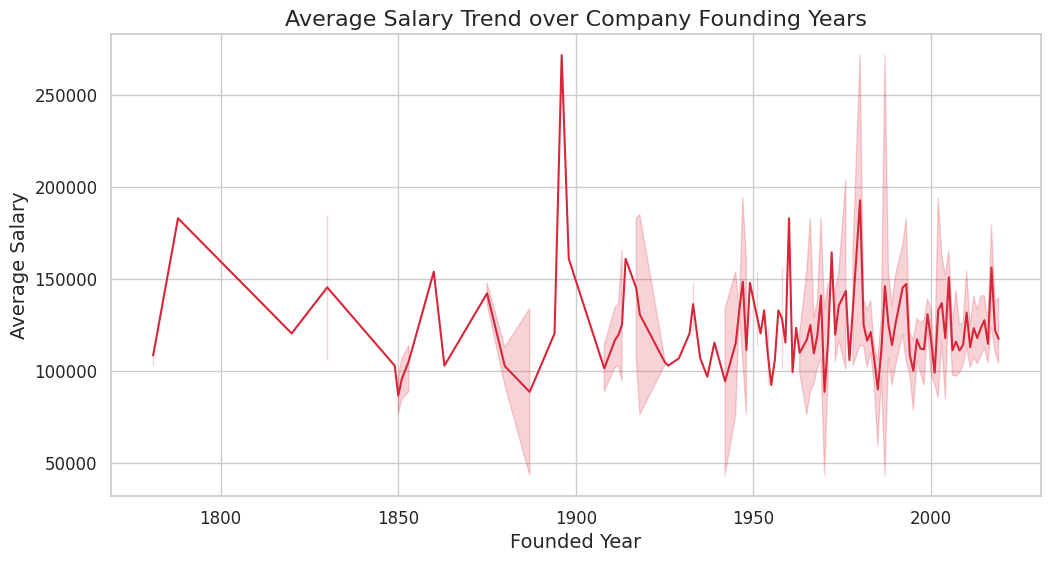

In [68]:
# Line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='FoundedYear', y='AverageSalary', data=df)
plt.xlabel('Founded Year')
plt.ylabel('Average Salary')
plt.title('Average Salary Trend over Company Founding Years')
plt.show()

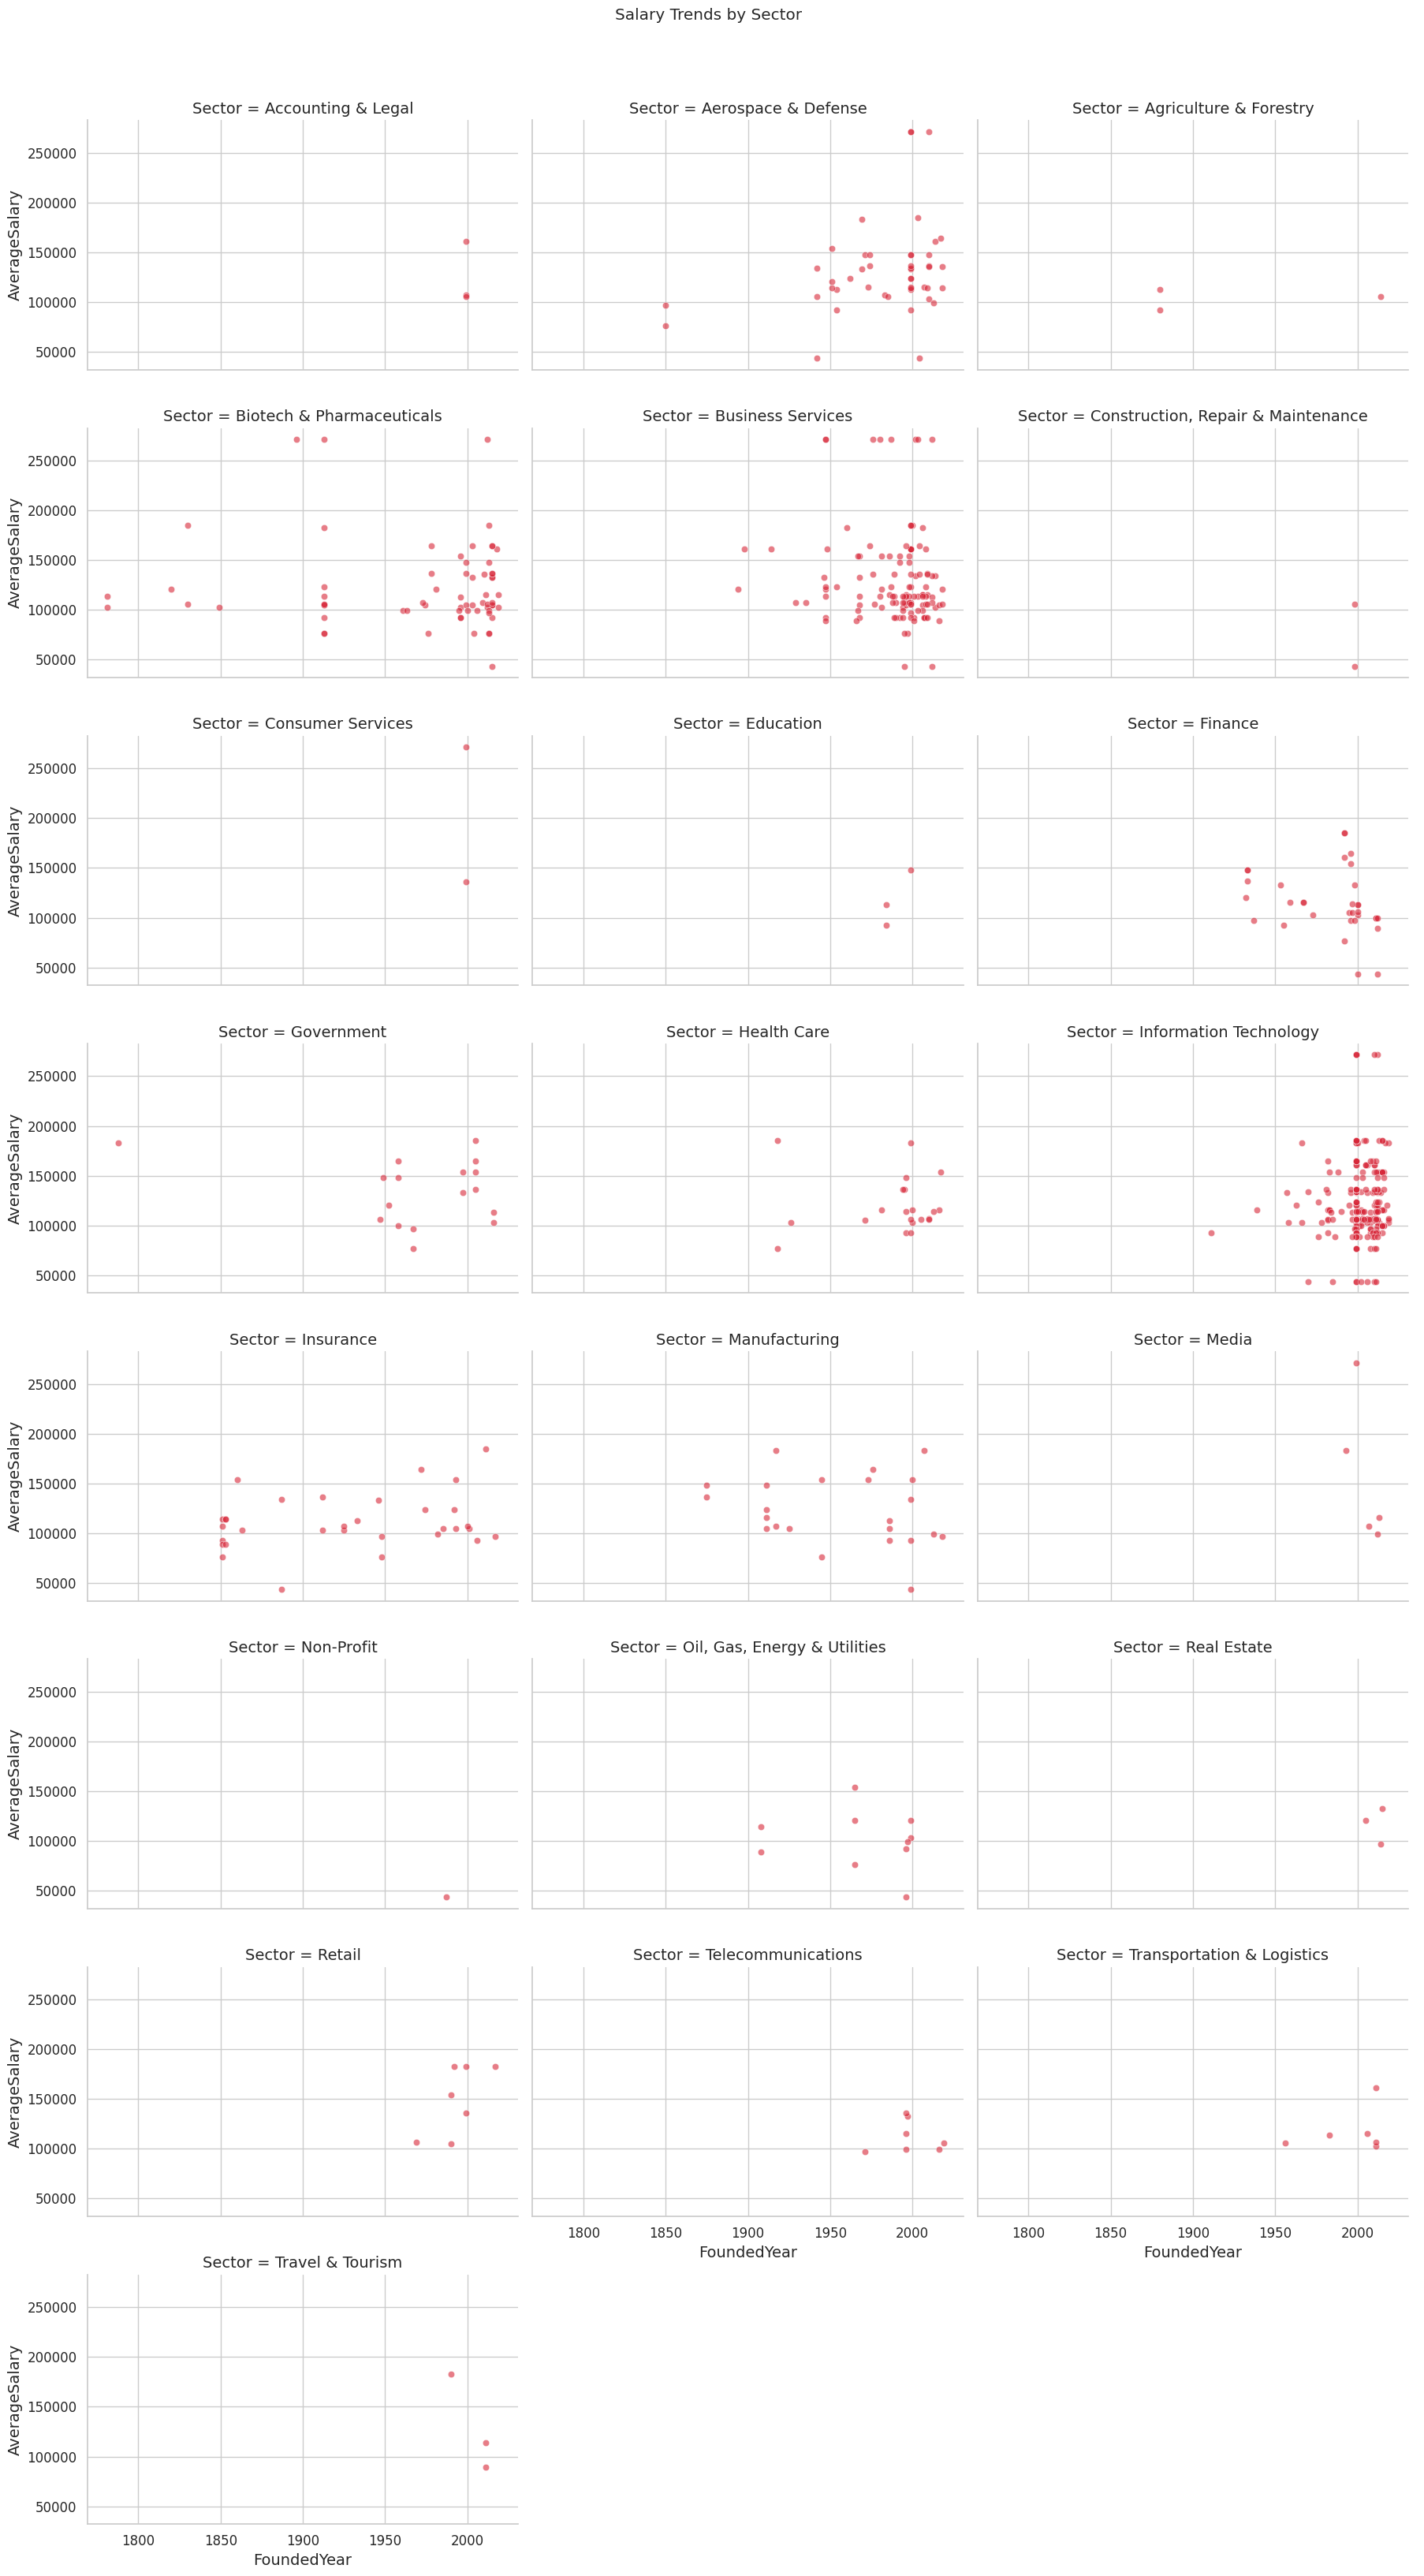

In [69]:
# Faceted scatter plot
g = sns.FacetGrid(df, col="Sector", col_wrap=3, height=4, aspect=1.5)
g.map(sns.scatterplot, "FoundedYear", "AverageSalary", alpha=0.6)
g.add_legend()
g.fig.suptitle('Salary Trends by Sector', y=1.02)
plt.tight_layout()
plt.show()

In [70]:
from sklearn.linear_model import LinearRegression
# Sectors with steepest increase in salaries
sector_slopes = {}
for sector in df['Sector'].unique():
    sector_data = df[df['Sector'] == sector]
    X = sector_data[['FoundedYear']]
    y = sector_data['AverageSalary']
    reg = LinearRegression().fit(X, y)
    sector_slopes[sector] = reg.coef_[0]

top_sectors = sorted(sector_slopes.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 sectors with steepest increase in salaries:")
for sector, slope in top_sectors:
    print(f"{sector}: {slope:.2f}")


Top 5 sectors with steepest increase in salaries:
Education: 3016.67
Retail: 1635.66
Aerospace & Defense: 388.18
Transportation & Logistics: 299.80
Information Technology: 187.91


Looking at the top 5 sectors with the steepest salary increases, I see some clear opportunities and insights:

1. **Education and Retail Stand Out**: The Education sector shows a notable jump in salaries, which suggests a growing demand for skilled professionals. Retail isn’t far behind, either. It makes me think that these industries might be worth focusing on, especially when it comes to hiring and retaining talent.

2. **Aerospace & Defense is Worth Watching**: The increase in salaries in Aerospace & Defense, while smaller, could indicate some interesting developments in that field. I’d keep an eye on it to see if the growth continues; it might lead to new opportunities down the road.

3. **Budgeting for Competitive Salaries**: With these trends, it’s clear that organizations will need to adjust their budgets to stay competitive. We might need to rethink how we allocate resources for salaries in these rising sectors.

4. **Collaborate with Growing Sectors**: The increasing demand for talent in these areas suggests there might be good opportunities for partnerships. Working with companies in these sectors could lead to mutual benefits.

5. **Upskilling in Information Technology**: Although IT shows a smaller salary increase, it’s still significant. Investing in training programs could help bridge the gap and ensure our workforce stays relevant and competitive.

6. **Leverage Salary Trends**: For companies in Education and Retail, promoting these salary increases can be a strong selling point in attracting top talent. It’s all about showing that we value our employees and are committed to competitive compensation.

7. **Think Long-Term**: I’d also want to assess whether these salary increases are sustainable. It’s important to consider how they align with market trends and the overall economy.

# Skills and Salary Correlation Analysis

In [71]:
# Explode the RequiredSkills column
df_exploded_skills = df.explode('RequiredSkills')

In [72]:
# Create binary columns for each skill
skills = df_exploded_skills['RequiredSkills'].str.get_dummies(', ')

In [73]:
print(skills.corr())

             C++      Java     Julia    Python         R       SQL     Scala
C++     1.000000 -0.065228 -0.014653 -0.124821 -0.155641 -0.101253 -0.065662
Java   -0.065228  1.000000 -0.020802 -0.177205 -0.220959 -0.143746 -0.093219
Julia  -0.014653 -0.020802  1.000000 -0.039807 -0.049636 -0.032291 -0.020940
Python -0.124821 -0.177205 -0.039807  1.000000 -0.422828 -0.275073 -0.178383
R      -0.155641 -0.220959 -0.049636 -0.422828  1.000000 -0.342992 -0.222428
SQL    -0.101253 -0.143746 -0.032291 -0.275073 -0.342992  1.000000 -0.144702
Scala  -0.065662 -0.093219 -0.020940 -0.178383 -0.222428 -0.144702  1.000000


### Insights from the Correlation Matrix of Programming Languages

1. **Python Shows Strong Negativity**: Python has the most significant negative correlation with R (-0.422) and SQL (-0.275). This suggests that as proficiency in Python increases, proficiency in R and SQL tends to decrease, indicating a potential trade-off in skillsets.

2. **Java and R**: The negative correlation between Java and R (-0.221) indicates that those skilled in Java may not necessarily excel in R, which could be worth considering when building a team.

3. **C++ and Python**: C++ also has a notable negative correlation with Python (-0.125), suggesting a similar pattern where expertise in one might not align with expertise in the other.

4. **Low Correlations Among Other Languages**: The correlations among the other languages (e.g., C++, Java, Julia, and Scala) are relatively low, indicating that proficiency in one does not significantly impact proficiency in the others.

5. **Consider Language Selection**: When selecting languages for projects or hiring, it might be beneficial to consider these correlations, as skills in one language may not translate to others.


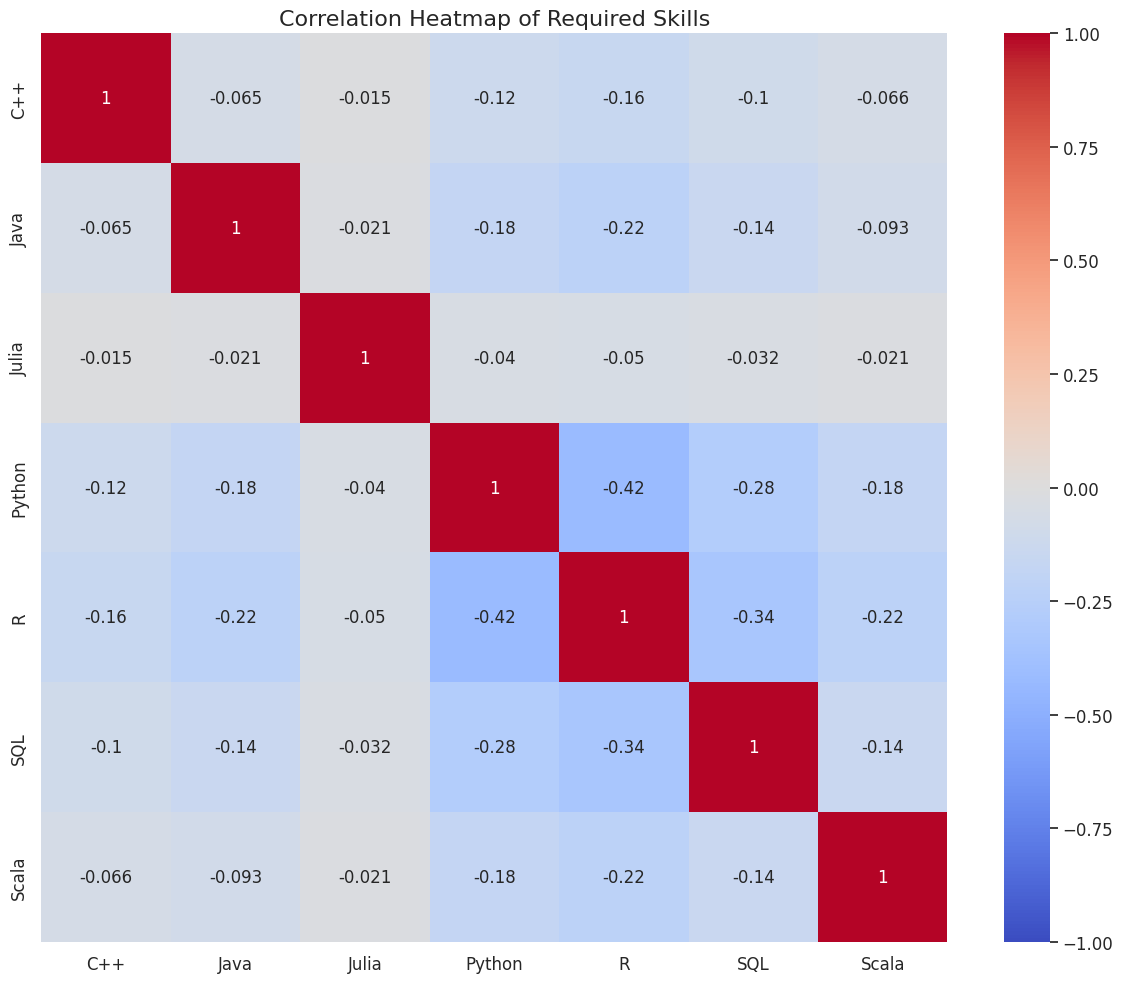

In [74]:
# Heatmap of skill correlations
plt.figure(figsize=(12, 10))
sns.heatmap(skills.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Required Skills')
plt.tight_layout()
plt.show()

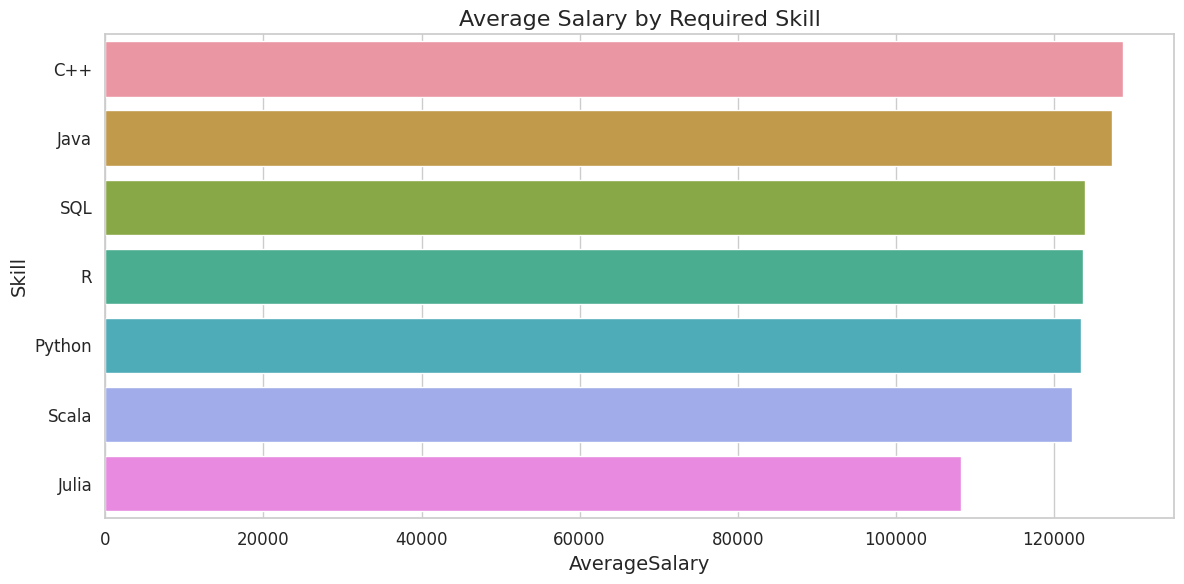

In [75]:
average_salaries = []
for skill in skills.columns:
    average_salary = df_exploded_skills[df_exploded_skills['RequiredSkills'] == skill]['AverageSalary'].mean()
    average_salaries.append(average_salary)

# Create a DataFrame for skills and their average salaries
skill_salaries = pd.DataFrame({
    'Skill': skills.columns,
    'AverageSalary': average_salaries
}).sort_values('AverageSalary', ascending=False)

# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='AverageSalary', y='Skill', data=skill_salaries)
plt.title('Average Salary by Required Skill')
plt.tight_layout()
plt.show()

In [76]:
# Top 5 skills with highest impact on salary
top_skills = skill_salaries.head()
print("Top 5 skills with highest impact on salary:")
print(top_skills)

Top 5 skills with highest impact on salary:
    Skill  AverageSalary
0     C++  128764.705882
1    Java  127350.609756
5     SQL  123960.339943
4       R  123657.934132
3  Python  123413.265306


# Geographical Distribution of Jobs and Salaries

In [77]:
# Choropleth map of job counts by state
state_job_counts = df['State'].value_counts().reset_index()
state_job_counts.columns = ['State', 'JobCount']

fig = px.choropleth(state_job_counts,
                    locations='State', 
                    locationmode="USA-states", 
                    color='JobCount',
                    scope="usa",
                    color_continuous_scale="Viridis",
                    title="Job Distribution Across States")
fig.show()

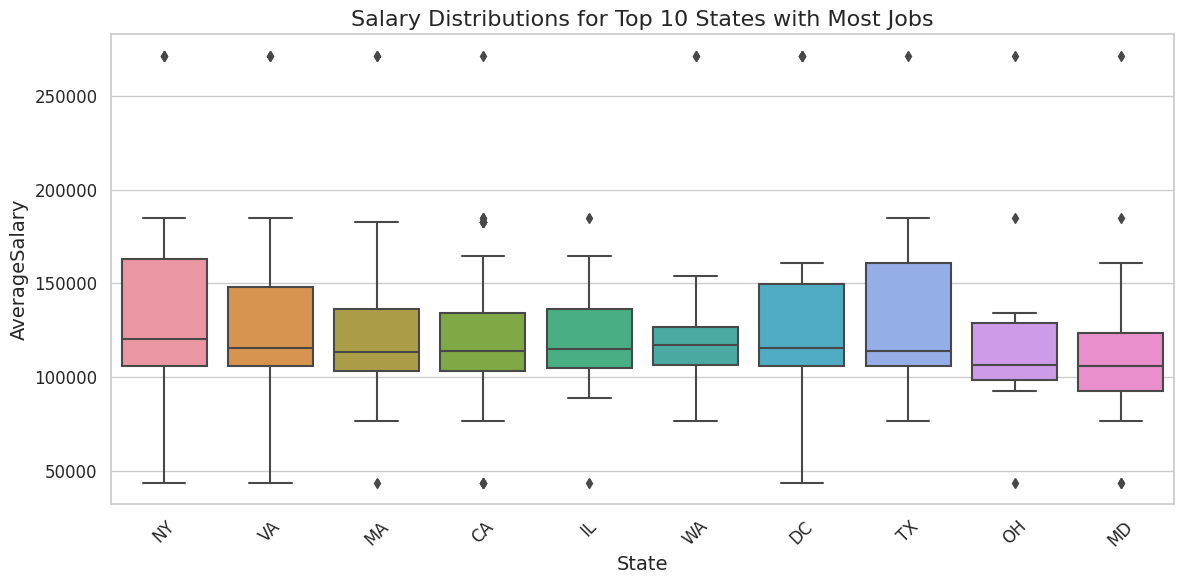

In [78]:
# Box plot of salary distributions for top 10 states
top_10_states = df['State'].value_counts().nlargest(10).index
df_top_10 = df[df['State'].isin(top_10_states)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='State', y='AverageSalary', data=df_top_10)
plt.title('Salary Distributions for Top 10 States with Most Jobs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [79]:
state_stats = df.groupby('State').agg({
    'JobTitle': 'count',
    'AverageSalary': 'median'
}).sort_values('JobTitle', ascending=False).head(5)

print("\nTop 5 states with highest job concentration and their median salaries:")
print(state_stats)


Top 5 states with highest job concentration and their median salaries:
       JobTitle  AverageSalary
State                         
CA          164       114000.0
VA           87       115500.0
MA           62       113500.0
NY           51       120500.0
MD           40       106000.0


# Company Ownership Type Analysis

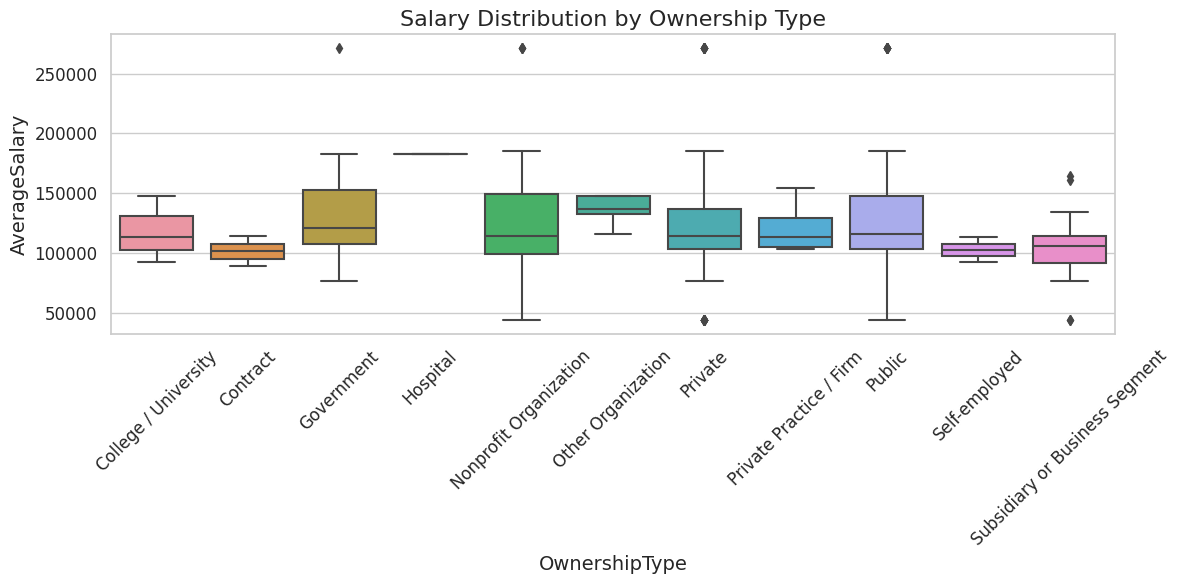

In [80]:
# Grouped box plot of salaries by ownership type
plt.figure(figsize=(12, 6))
sns.boxplot(x='OwnershipType', y='AverageSalary', data=df)
plt.title('Salary Distribution by Ownership Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

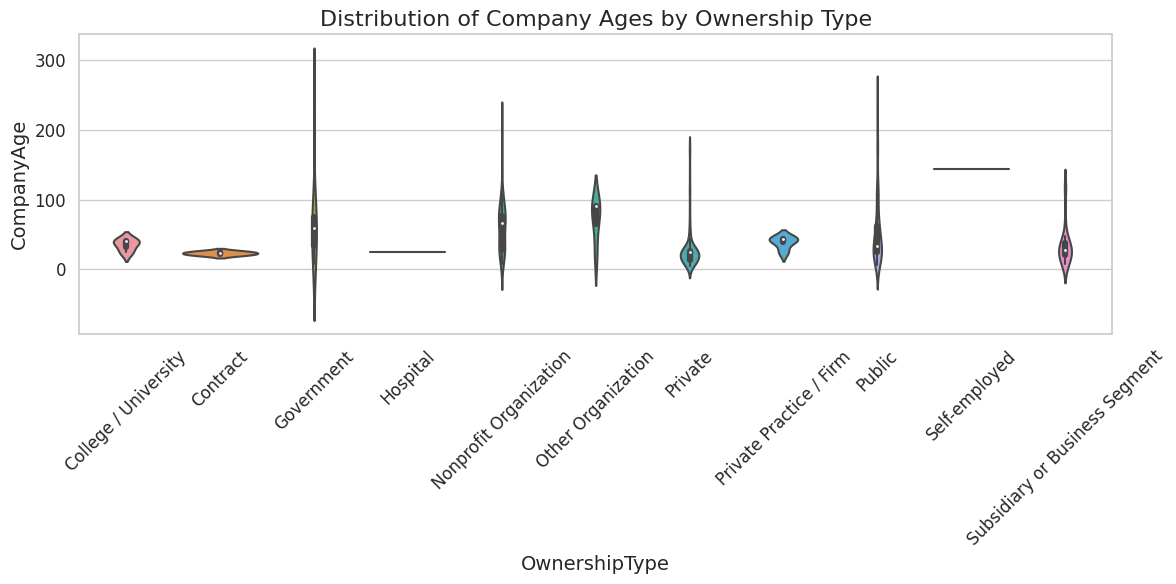

In [81]:
# Violin plot of company ages for each ownership type
plt.figure(figsize=(12, 6))
sns.violinplot(x='OwnershipType', y='CompanyAge', data=df)
plt.title('Distribution of Company Ages by Ownership Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [82]:
# Ownership type with highest median salary and oldest companies
ownership_stats = df.groupby('OwnershipType').agg({
    'AverageSalary': 'median',
    'CompanyAge': 'max'
}).sort_values('AverageSalary', ascending=False)

print("\nOwnership type statistics:")
print(ownership_stats)
print(f"\nOwnership type with highest median salary: {ownership_stats.index[0]}")
print(f"Ownership type with oldest companies: {ownership_stats['CompanyAge'].idxmax()}")


Ownership type statistics:
                                AverageSalary  CompanyAge
OwnershipType                                            
Hospital                             183000.0        25.0
Other Organization                   136500.0        91.0
Government                           120500.0       236.0
Public                               115500.0       243.0
Nonprofit Organization               114000.0       204.0
Private                              114000.0       173.0
Private Practice / Firm              113250.0        43.0
College / University                 113000.0        40.0
Subsidiary or Business Segment       105500.0       116.0
Self-employed                        102750.0       144.0
Contract                             101500.0        25.0

Ownership type with highest median salary: Hospital
Ownership type with oldest companies: Public


# Revenue, Competitors, and Salary Analysis

In [83]:
# Bubble chart
fig = px.scatter(df, x='AverageRevenue', y='NumberOfCompetitors', size='AverageSalary',
                 hover_name='CompanyName', log_x=True, size_max=60,
                 title='Relationship between Revenue, Competitors, and Salary')
fig.show()

In [84]:
# Calculate Spearman's rank correlation
corr_revenue_competitors = stats.spearmanr(df['AverageRevenue'], df['NumberOfCompetitors'])
corr_revenue_salary = stats.spearmanr(df['AverageRevenue'], df['AverageSalary'])
corr_competitors_salary = stats.spearmanr(df['NumberOfCompetitors'], df['AverageSalary'])

print("Spearman's rank correlation results:")
print(f"Revenue vs Competitors: {corr_revenue_competitors[0]:.2f} (p-value: {corr_revenue_competitors[1]:.4f})")
print(f"Revenue vs Salary: {corr_revenue_salary[0]:.2f} (p-value: {corr_revenue_salary[1]:.4f})")
print(f"Competitors vs Salary: {corr_competitors_salary[0]:.2f} (p-value: {corr_competitors_salary[1]:.4f})")

Spearman's rank correlation results:
Revenue vs Competitors: 0.12 (p-value: 0.0024)
Revenue vs Salary: 0.06 (p-value: 0.0935)
Competitors vs Salary: -0.00 (p-value: 0.9279)


### Insights from Spearman's Rank Correlation Results

1. **Revenue vs Competitors**: 
   - **Correlation Coefficient**: 0.12 
   - **P-value**: 0.0024 
   - **Interpretation**: There is a weak positive correlation between revenue and the number of competitors, and the low p-value indicates this result is statistically significant. This suggests that as revenue increases, the number of competitors tends to increase as well, although the correlation is not strong.

2. **Revenue vs Salary**: 
   - **Correlation Coefficient**: 0.06 
   - **P-value**: 0.0935 
   - **Interpretation**: The correlation between revenue and salary is very weak, and the p-value is close to the threshold for significance (usually 0.05). This implies that while there may be a slight positive relationship, it is not strong enough to draw definitive conclusions.

3. **Competitors vs Salary**: 
   - **Correlation Coefficient**: -0.00 
   - **P-value**: 0.9279 
   - **Interpretation**: There is virtually no correlation between the number of competitors and salary, and the high p-value indicates that this result is not statistically significant. This suggests that the presence of competitors does not impact salary levels.

---

### Overall Conclusion

- The only noteworthy relationship is between revenue and competitors, which suggests a possible link worth exploring further. However, the other correlations indicate minimal or no significant relationships among the variables, emphasizing the complexity of these dynamics.

In [85]:
# Find revenue-competitor combination associated with highest salaries
df['RevComp'] = df['AverageRevenue'].astype(str) + '_' + df['NumberOfCompetitors'].astype(str)
highest_salary_combo = df.groupby('RevComp')['AverageSalary'].mean().idxmax()
highest_salary = df.groupby('RevComp')['AverageSalary'].mean().max()

revenue, competitors = highest_salary_combo.split('_')
print(f"\nRevenue-competitor combination associated with highest salaries:")
print(f"Average Revenue: {revenue}")
print(f"Number of Competitors: {competitors}")
print(f"Average Salary: ${highest_salary:.2f}")


Revenue-competitor combination associated with highest salaries:
Average Revenue: 2060000000.0
Number of Competitors: 2
Average Salary: $271500.00


# Experience, Skills, and Education Analysis

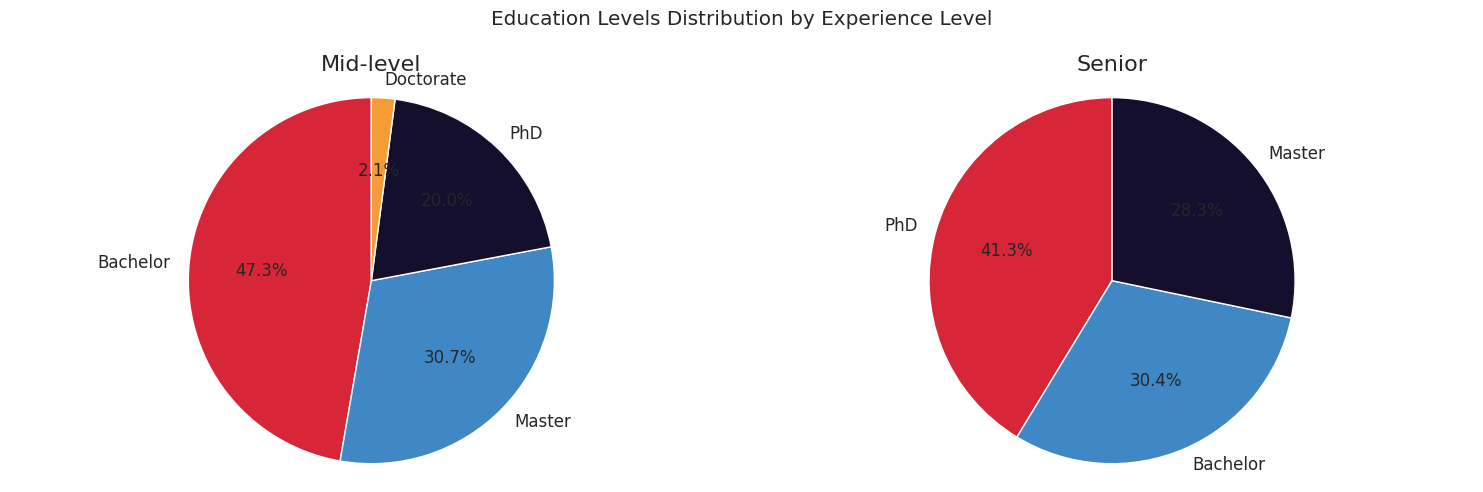

In [86]:
df_exploded_edu = df.explode('EducationLevel')

# Pie charts for each experience level
experience_levels = df_exploded_edu['ExperienceLevel'].unique()
fig, axes = plt.subplots(1, len(experience_levels), figsize=(15, 5))

for ax, exp_level in zip(axes, experience_levels):
    data = df_exploded_edu[df_exploded_edu['ExperienceLevel'] == exp_level]['EducationLevel'].value_counts()
    ax.pie(data, labels=data.index, autopct='%1.1f%%', startangle=90)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax.set_title(exp_level)

plt.suptitle('Education Levels Distribution by Experience Level')
plt.tight_layout()
plt.show()

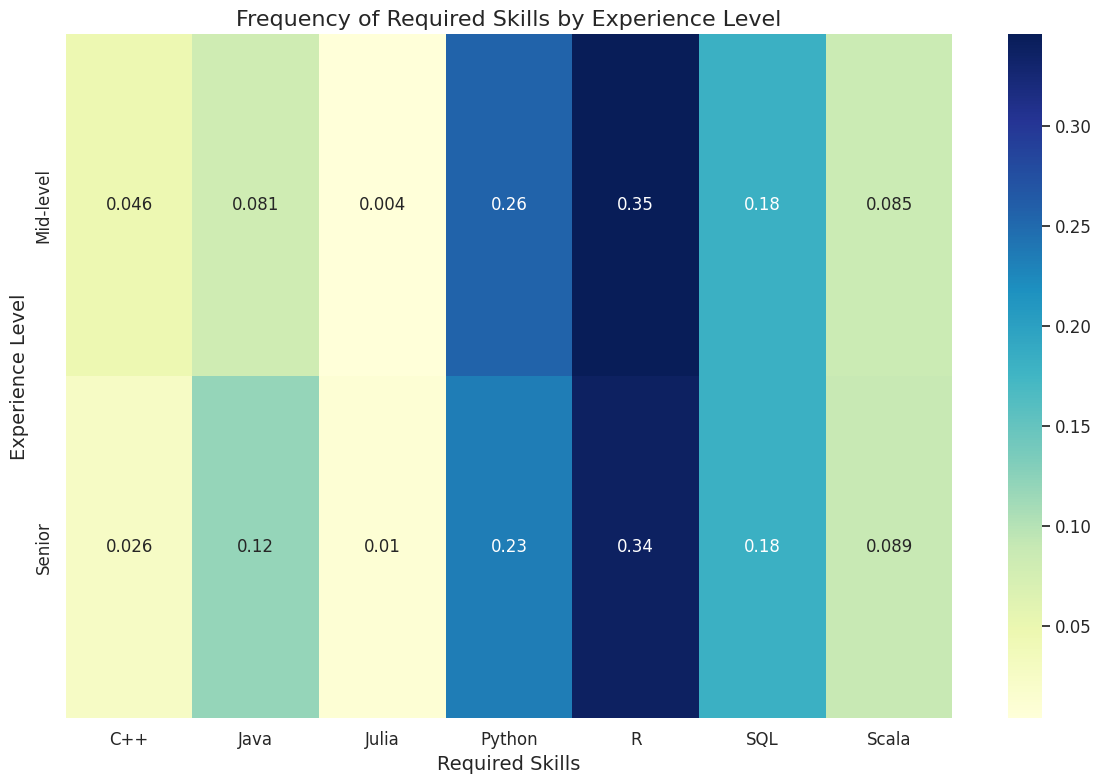

In [87]:
df_exploded_skills = df.explode('RequiredSkills')

skills = df_exploded_skills['RequiredSkills'].str.get_dummies(', ')

# Group by ExperienceLevel and calculate the mean of each skill
skill_exp = skills.groupby(df_exploded_skills['ExperienceLevel']).mean()

# Heatmap of required skills for each experience level
plt.figure(figsize=(12, 8))
sns.heatmap(skill_exp, annot=True, cmap='YlGnBu')
plt.title('Frequency of Required Skills by Experience Level')
plt.xlabel('Required Skills')
plt.ylabel('Experience Level')
plt.tight_layout()
plt.show()

In [88]:
# Explode the RequiredSkills column
df_exploded_skills = df.explode('RequiredSkills')

# Explode the EducationLevel column
df_exploded_edu = df_exploded_skills.explode('EducationLevel')

# Most common skill-education combinations for each experience level
for exp_level in df['ExperienceLevel'].unique():
    exp_df = df_exploded_edu[df_exploded_edu['ExperienceLevel'] == exp_level]
    
    # Find the most common education level
    top_edu = exp_df['EducationLevel'].mode().values[0]
    
    # Find the top 3 skills
    top_skills = exp_df['RequiredSkills'].value_counts().head(3).index.tolist()
    
    print(f"\nExperience Level: {exp_level}")
    print(f"Most common education: {top_edu}")
    print(f"Top 3 skills: {', '.join(top_skills)}")


Experience Level: Mid-level
Most common education: Bachelor
Top 3 skills: R, Python, SQL

Experience Level: Senior
Most common education: PhD
Top 3 skills: R, Python, SQL


# Salary Categories, Industries, and Ratings Analysis

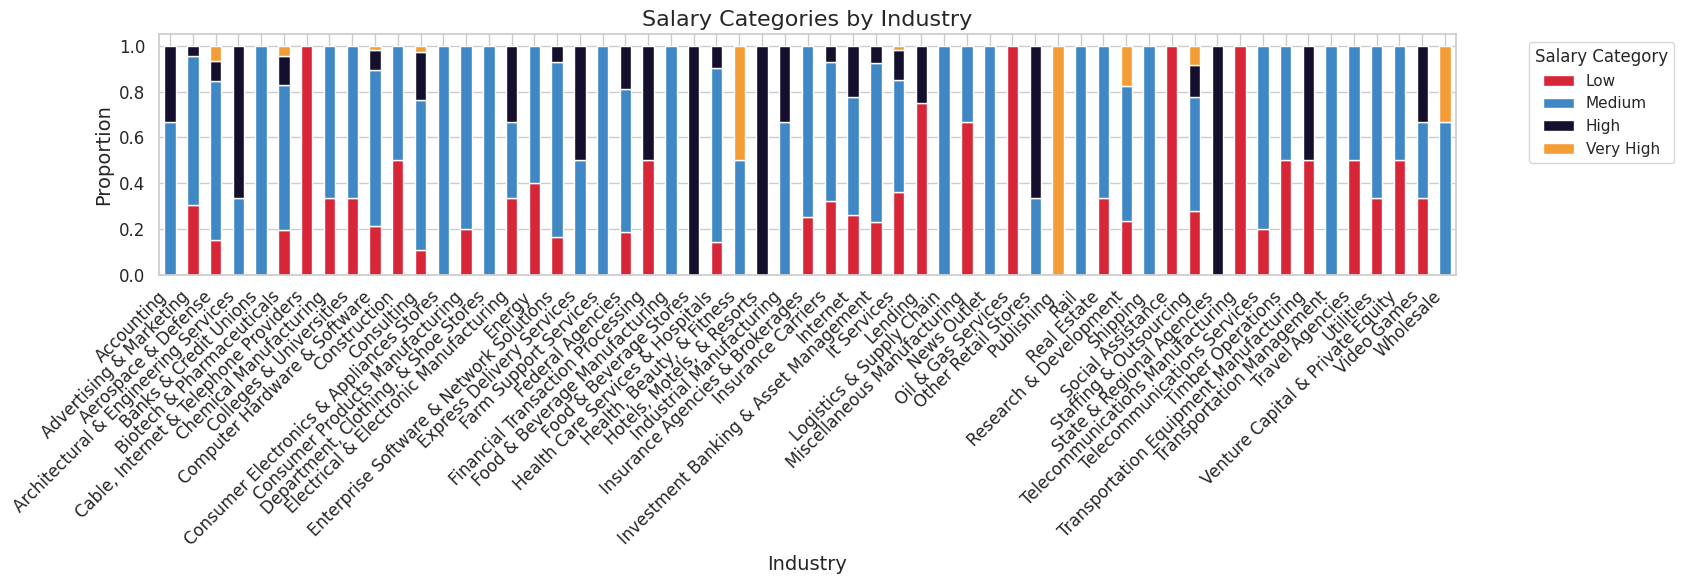

In [89]:
# Stacked bar chart of salary categories for each industry
salary_industry = pd.crosstab(df['Industry'], df['SalaryCategory'], normalize='index')
salary_industry.plot(kind='bar', stacked=True, figsize=(17, 6))
plt.title('Salary Categories by Industry')
plt.xlabel('Industry')
plt.ylabel('Proportion')
plt.legend(title='Salary Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

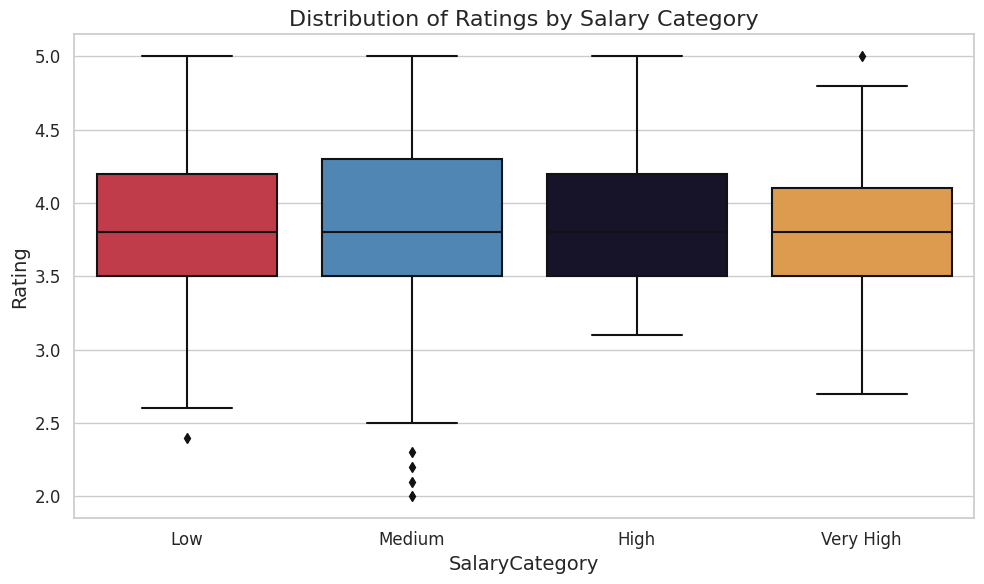

In [90]:
# Box plot of ratings for each salary category
plt.figure(figsize=(10, 6))
sns.boxplot(x='SalaryCategory', y='Rating', data=df)
plt.title('Distribution of Ratings by Salary Category')
plt.tight_layout()
plt.show()

In [91]:
# Industries with the highest proportion of high-salary jobs and their average ratings
high_salary_prop = salary_industry['High'].sort_values(ascending=False).head(5)
industry_ratings = df.groupby('Industry')['Rating'].mean()

print("\nTop 5 industries with highest proportion of high-salary jobs:")
for industry in high_salary_prop.index:
    print(f"{industry}:")
    print(f"  Proportion of high-salary jobs: {high_salary_prop[industry]:.2%}")
    print(f"  Average rating: {industry_ratings[industry]:.2f}")


Top 5 industries with highest proportion of high-salary jobs:
Food & Beverage Stores:
  Proportion of high-salary jobs: 100.00%
  Average rating: 3.70
State & Regional Agencies:
  Proportion of high-salary jobs: 100.00%
  Average rating: 3.20
Hotels, Motels, & Resorts:
  Proportion of high-salary jobs: 100.00%
  Average rating: 3.50
Architectural & Engineering Services:
  Proportion of high-salary jobs: 66.67%
  Average rating: 3.60
Other Retail Stores:
  Proportion of high-salary jobs: 66.67%
  Average rating: 3.67


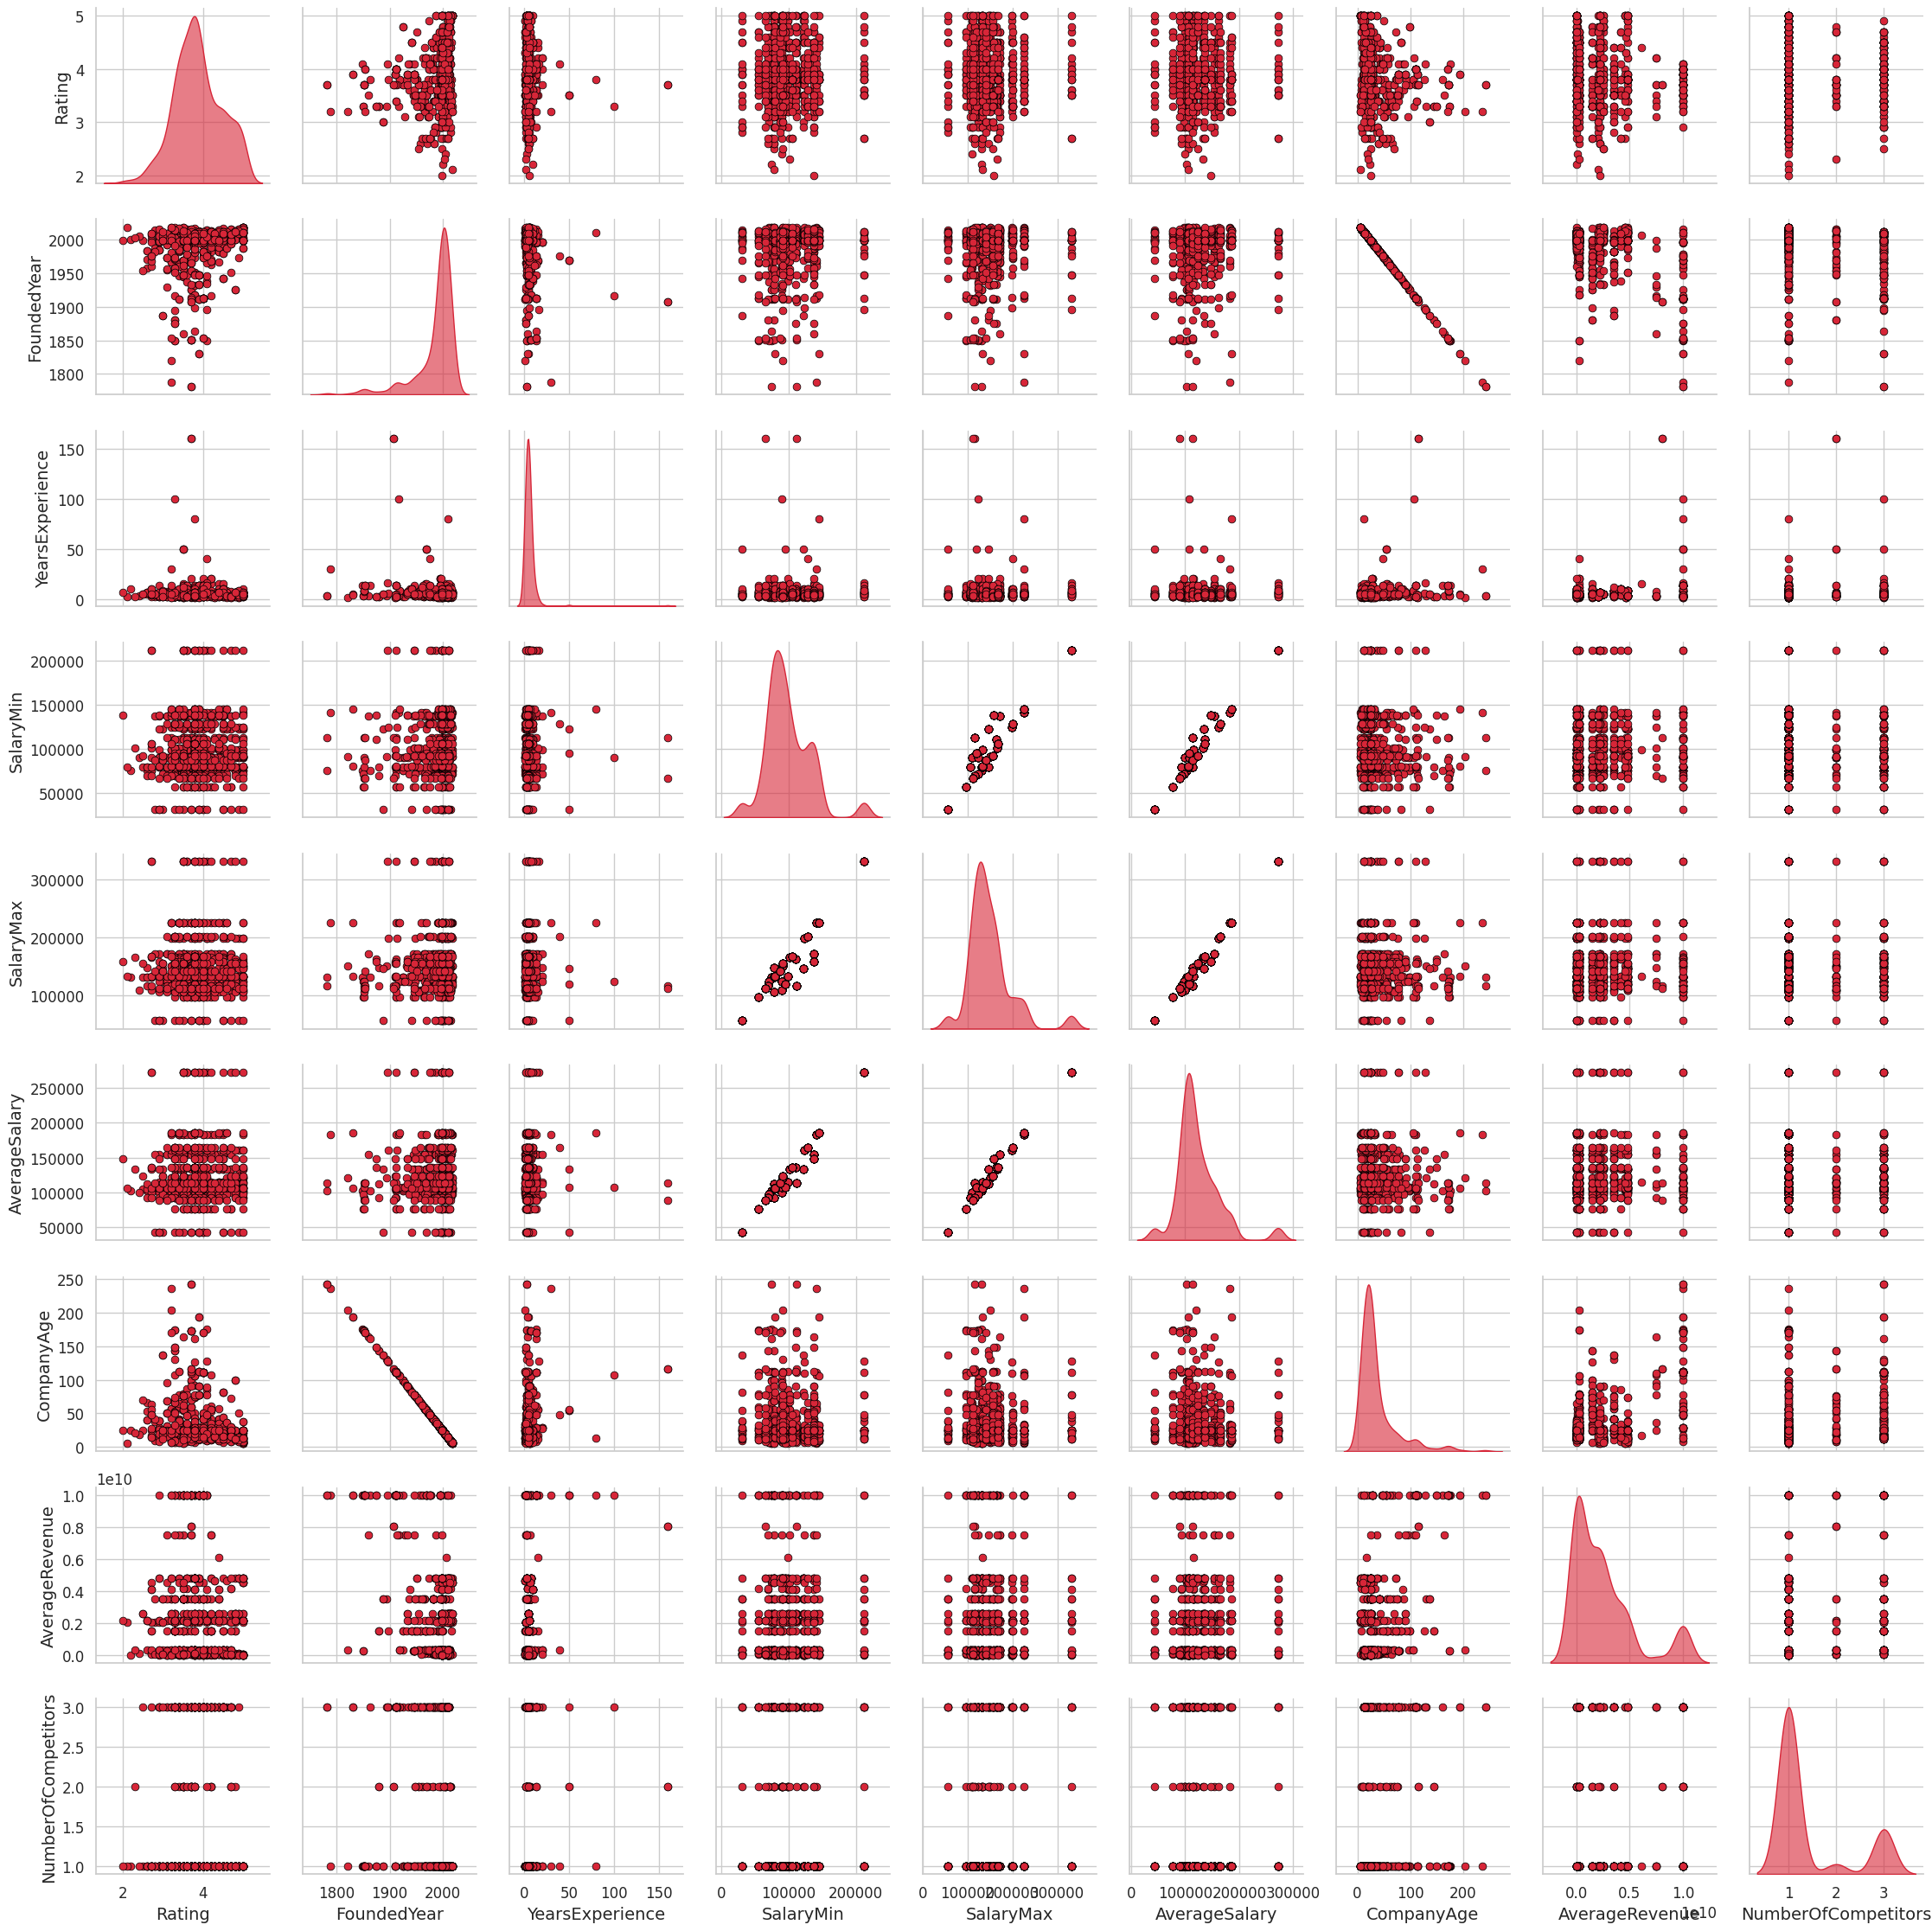

In [92]:
sns.pairplot(df, 
             palette=custom_colors,  # Use your custom palette
             markers=["o", "s", "D"],  # Different markers for better distinction
             plot_kws={'s': 40, 'edgecolor': 'k', 'linewidth': 0.5},  # Adjust marker size and style
             diag_kind='kde',  # Use KDE for diagonal plots
             diag_kws={'shade': True, 'alpha': 0.6},  # Adjust KDE shading
            )

# Improve the layout
plt.tight_layout()

# Display the plot
plt.show()

# Data Transformation Part

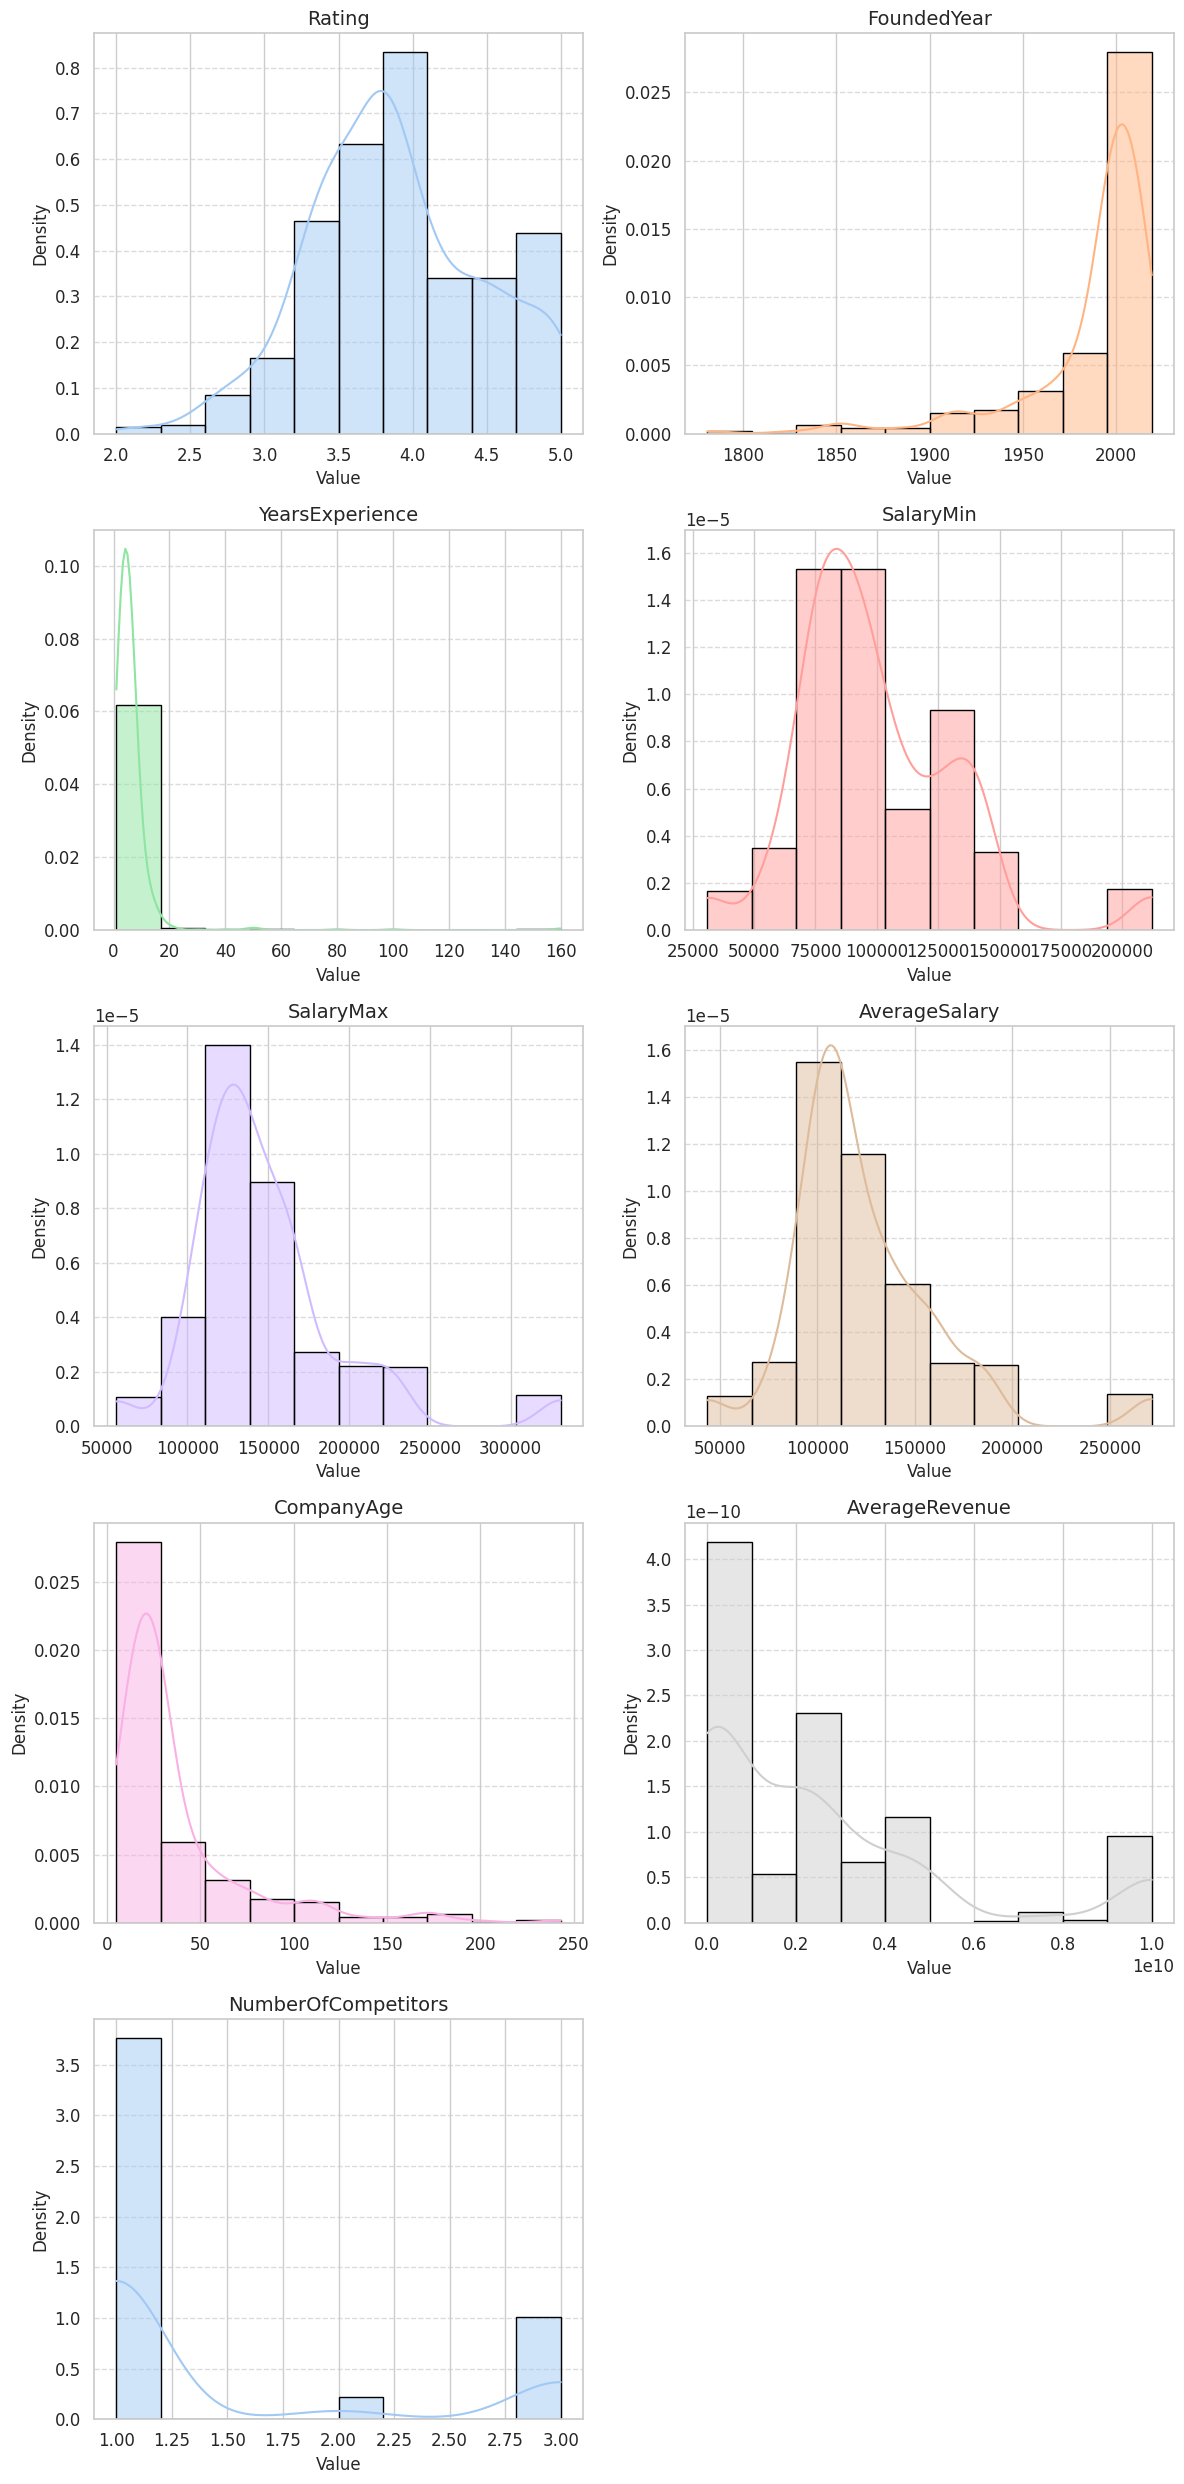

In [93]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns

# Set the number of rows and columns for subplots
num_cols = len(numeric_cols)
num_rows = (num_cols + 1) // 2  # Two plots per row

# Create a figure for the subplots
plt.figure(figsize=(12, num_rows * 5))

# Loop through each numeric column and create a histplot with KDE
for i, column in enumerate(numeric_cols):
    plt.subplot(num_rows, 2, i + 1)  # Adjust the subplot grid as needed
    sns.histplot(df[column], kde=True, color=sns.color_palette("pastel")[i % 8], bins=10, stat='density', edgecolor='black')
    plt.title(column, fontsize=14)
    plt.xlabel('Value', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

In [94]:
from scipy import stats

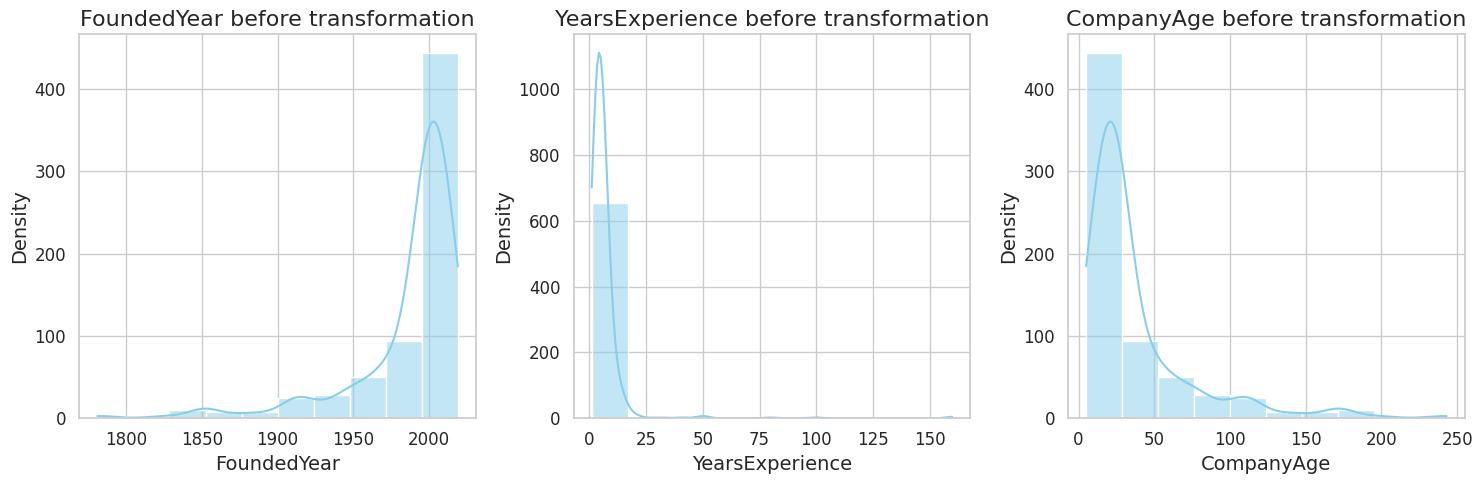

Skewness before transformation:
 FoundedYear        -2.528039
YearsExperience    10.975150
CompanyAge          2.528039
dtype: float64


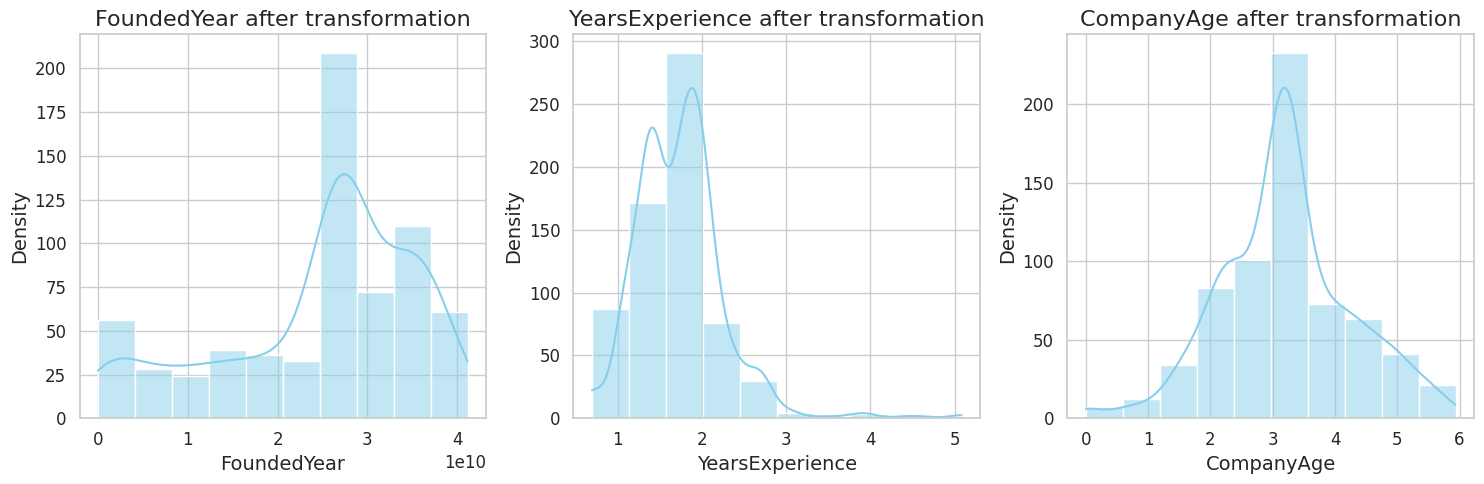

Skewness after transformation:
 FoundedYear       -0.828968
YearsExperience    1.625147
CompanyAge         0.003840
dtype: float64


In [95]:
# Function to visualize distributions
def plot_distributions(df, cols, title_suffix):
    plt.figure(figsize=(15, 5))
    for i, col in enumerate(cols):
        plt.subplot(1, len(cols), i + 1)
        sns.histplot(df[col], kde=True, color="skyblue", bins=10)
        plt.title(f'{col} {title_suffix}')
        plt.xlabel(col)
        plt.ylabel('Density')
    plt.tight_layout()
    plt.show()

# Step 1: Visualize original distributions
plot_distributions(df, ['FoundedYear', 'YearsExperience', 'CompanyAge'], 'before transformation')

# Step 2: Check skewness
skewness = df[['FoundedYear', 'YearsExperience', 'CompanyAge']].skew()
print("Skewness before transformation:\n", skewness)

# Step 3: Transform columns
# Apply Box-Cox transformation to FoundedYear and CompanyAge
def boxcox_transform(column):
    # Shift the data to avoid zero values
    transformed_column, _ = stats.boxcox(column - column.min() + 1)  
    return transformed_column

# Transform the columns
df['FoundedYear'] = boxcox_transform(df['FoundedYear'])
df['YearsExperience'] = np.log(df['YearsExperience'] + 1)  # Log transformation
df['CompanyAge'] = boxcox_transform(df['CompanyAge'])

# Step 4: Visualize transformed distributions
plot_distributions(df, ['FoundedYear', 'YearsExperience', 'CompanyAge'], 'after transformation')

# Check skewness after transformation
skewness_after = df[['FoundedYear', 'YearsExperience', 'CompanyAge']].skew()
print("Skewness after transformation:\n", skewness_after)

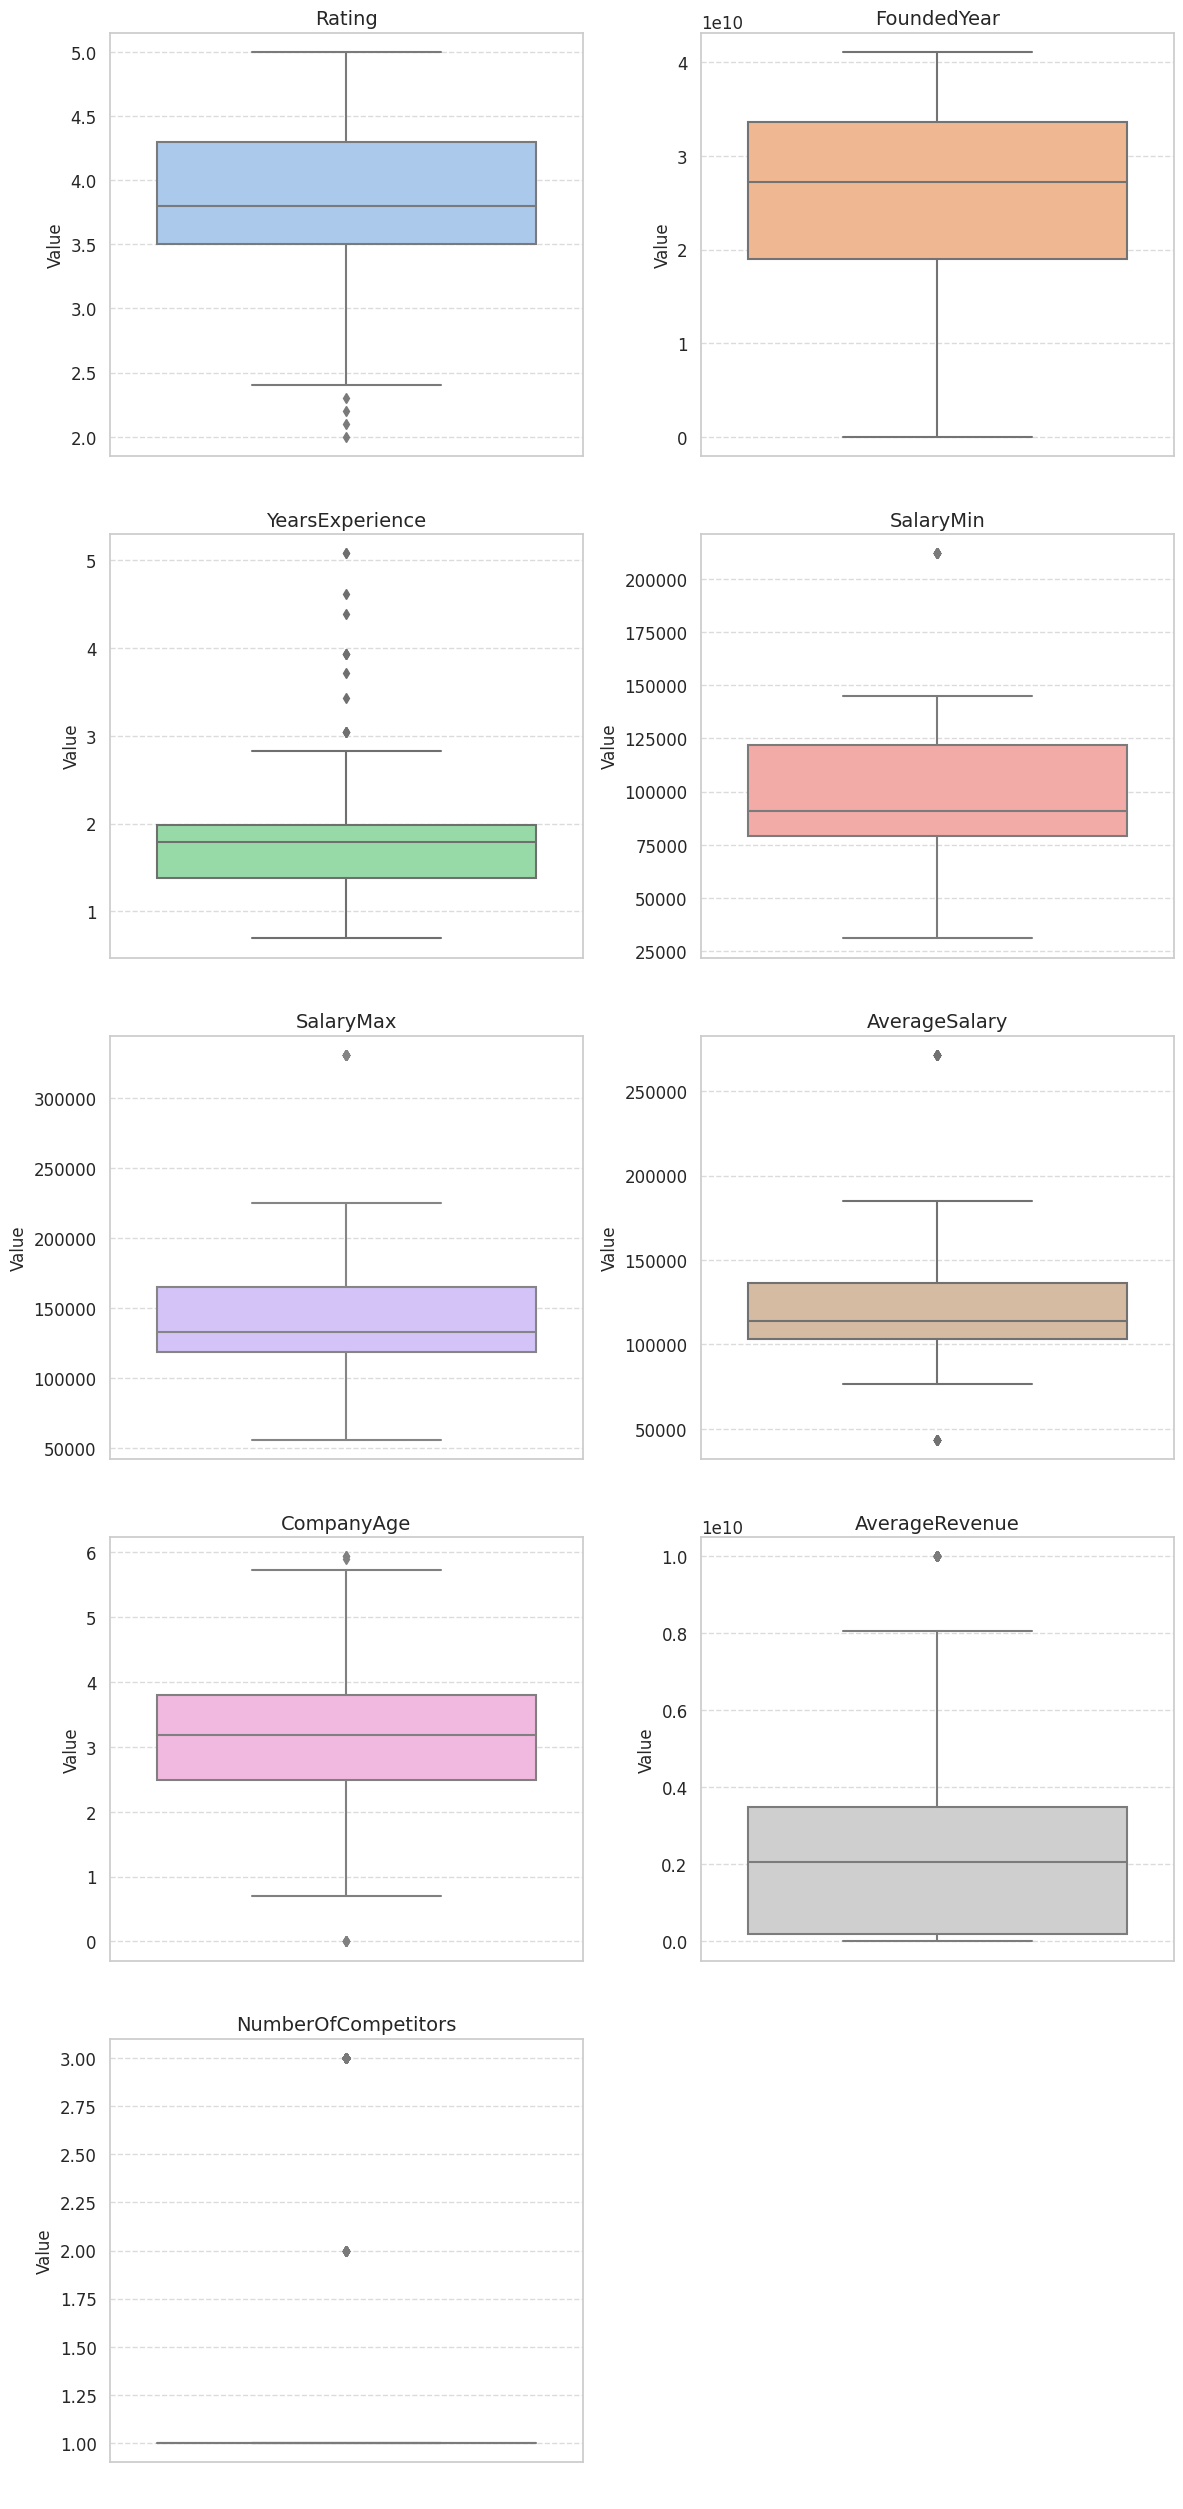

In [96]:
# Select the numeric col
numeric_col = df.select_dtypes(include='number')
# Set the number of rows and columns for subplots
num_cols = len(df.columns)
num_rows = (num_cols + 1) // 2  # Two plots per row

# Create a figure for the subplots
plt.figure(figsize=(12, num_rows * 5))

# Loop through each column and create a boxplot
for i, column in enumerate(numeric_col.columns):
    plt.subplot(num_rows, 2, i + 1)  # Adjust the subplot grid as needed
    sns.boxplot(y=df[column], color=sns.color_palette("pastel")[i % 8])  # Use pastel colors
    plt.title(column, fontsize=14)
    plt.ylabel('Value', fontsize=12)
    plt.xlabel(' ', fontsize=12)  # Label for the x-axis (empty for aesthetics)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

In [97]:
# Function to count outliers using IQR method
def count_outliers(df):
    outlier_counts = {}
    
    # Loop through each numeric column
    for col in df.select_dtypes(include=['number']).columns:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1  # Interquartile Range
        
        # Define bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Count outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_counts[col] = outliers.shape[0]  # Number of outliers
    
    return outlier_counts 

# Get the number of outliers in each numeric column
outlier_counts = count_outliers(df)

# Print the number of outliers for each column
for col, count in outlier_counts.items():
    print(f'Number of outliers in {col}: {count}')

Number of outliers in Rating: 4
Number of outliers in FoundedYear: 0
Number of outliers in YearsExperience: 13
Number of outliers in SalaryMin: 21
Number of outliers in SalaryMax: 21
Number of outliers in AverageSalary: 41
Number of outliers in CompanyAge: 10
Number of outliers in AverageRevenue: 64
Number of outliers in NumberOfCompetitors: 165


# Outliers (Imputation)

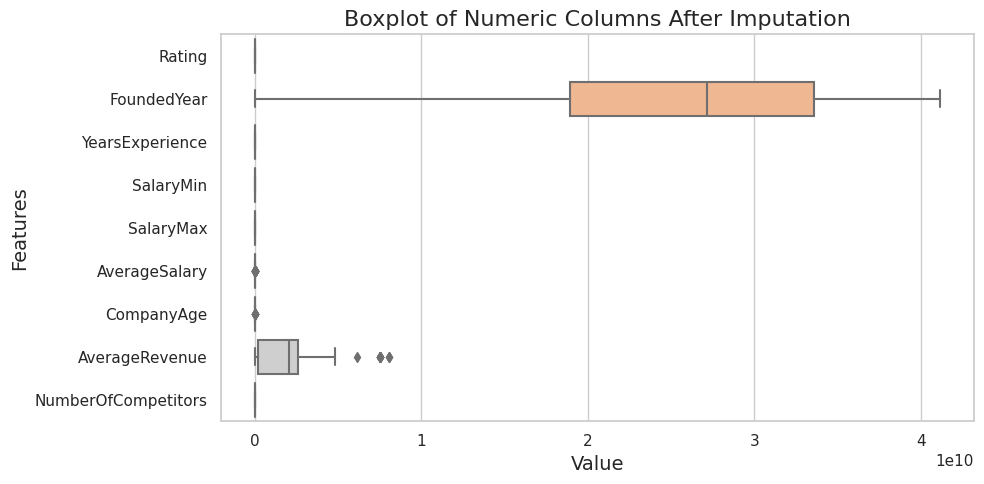

In [98]:
# Function to impute outliers with median
def impute_outliers(df):
    for col in df.select_dtypes(include=['number']).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Replace outliers with median
        median = df[col].median()
        df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), median, df[col])
    return df

# Impute outliers in the DataFrame
df_imputed = impute_outliers(df)

# Visualize the new boxplot after imputing outliers
def plot_boxplots(df):
    plt.figure(figsize=(10, 5))  # Adjusted figure size for clarity
    sns.set(style="whitegrid")  # Set a clean style

    # Create a horizontal boxplot
    sns.boxplot(data=df, orient="h", palette="pastel", fliersize=5)

    plt.title('Boxplot of Numeric Columns After Imputation', fontsize=16)
    plt.xlabel('Value', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    
    plt.tight_layout()
    plt.show()

# Plot boxplots for the imputed DataFrame
plot_boxplots(df_imputed)

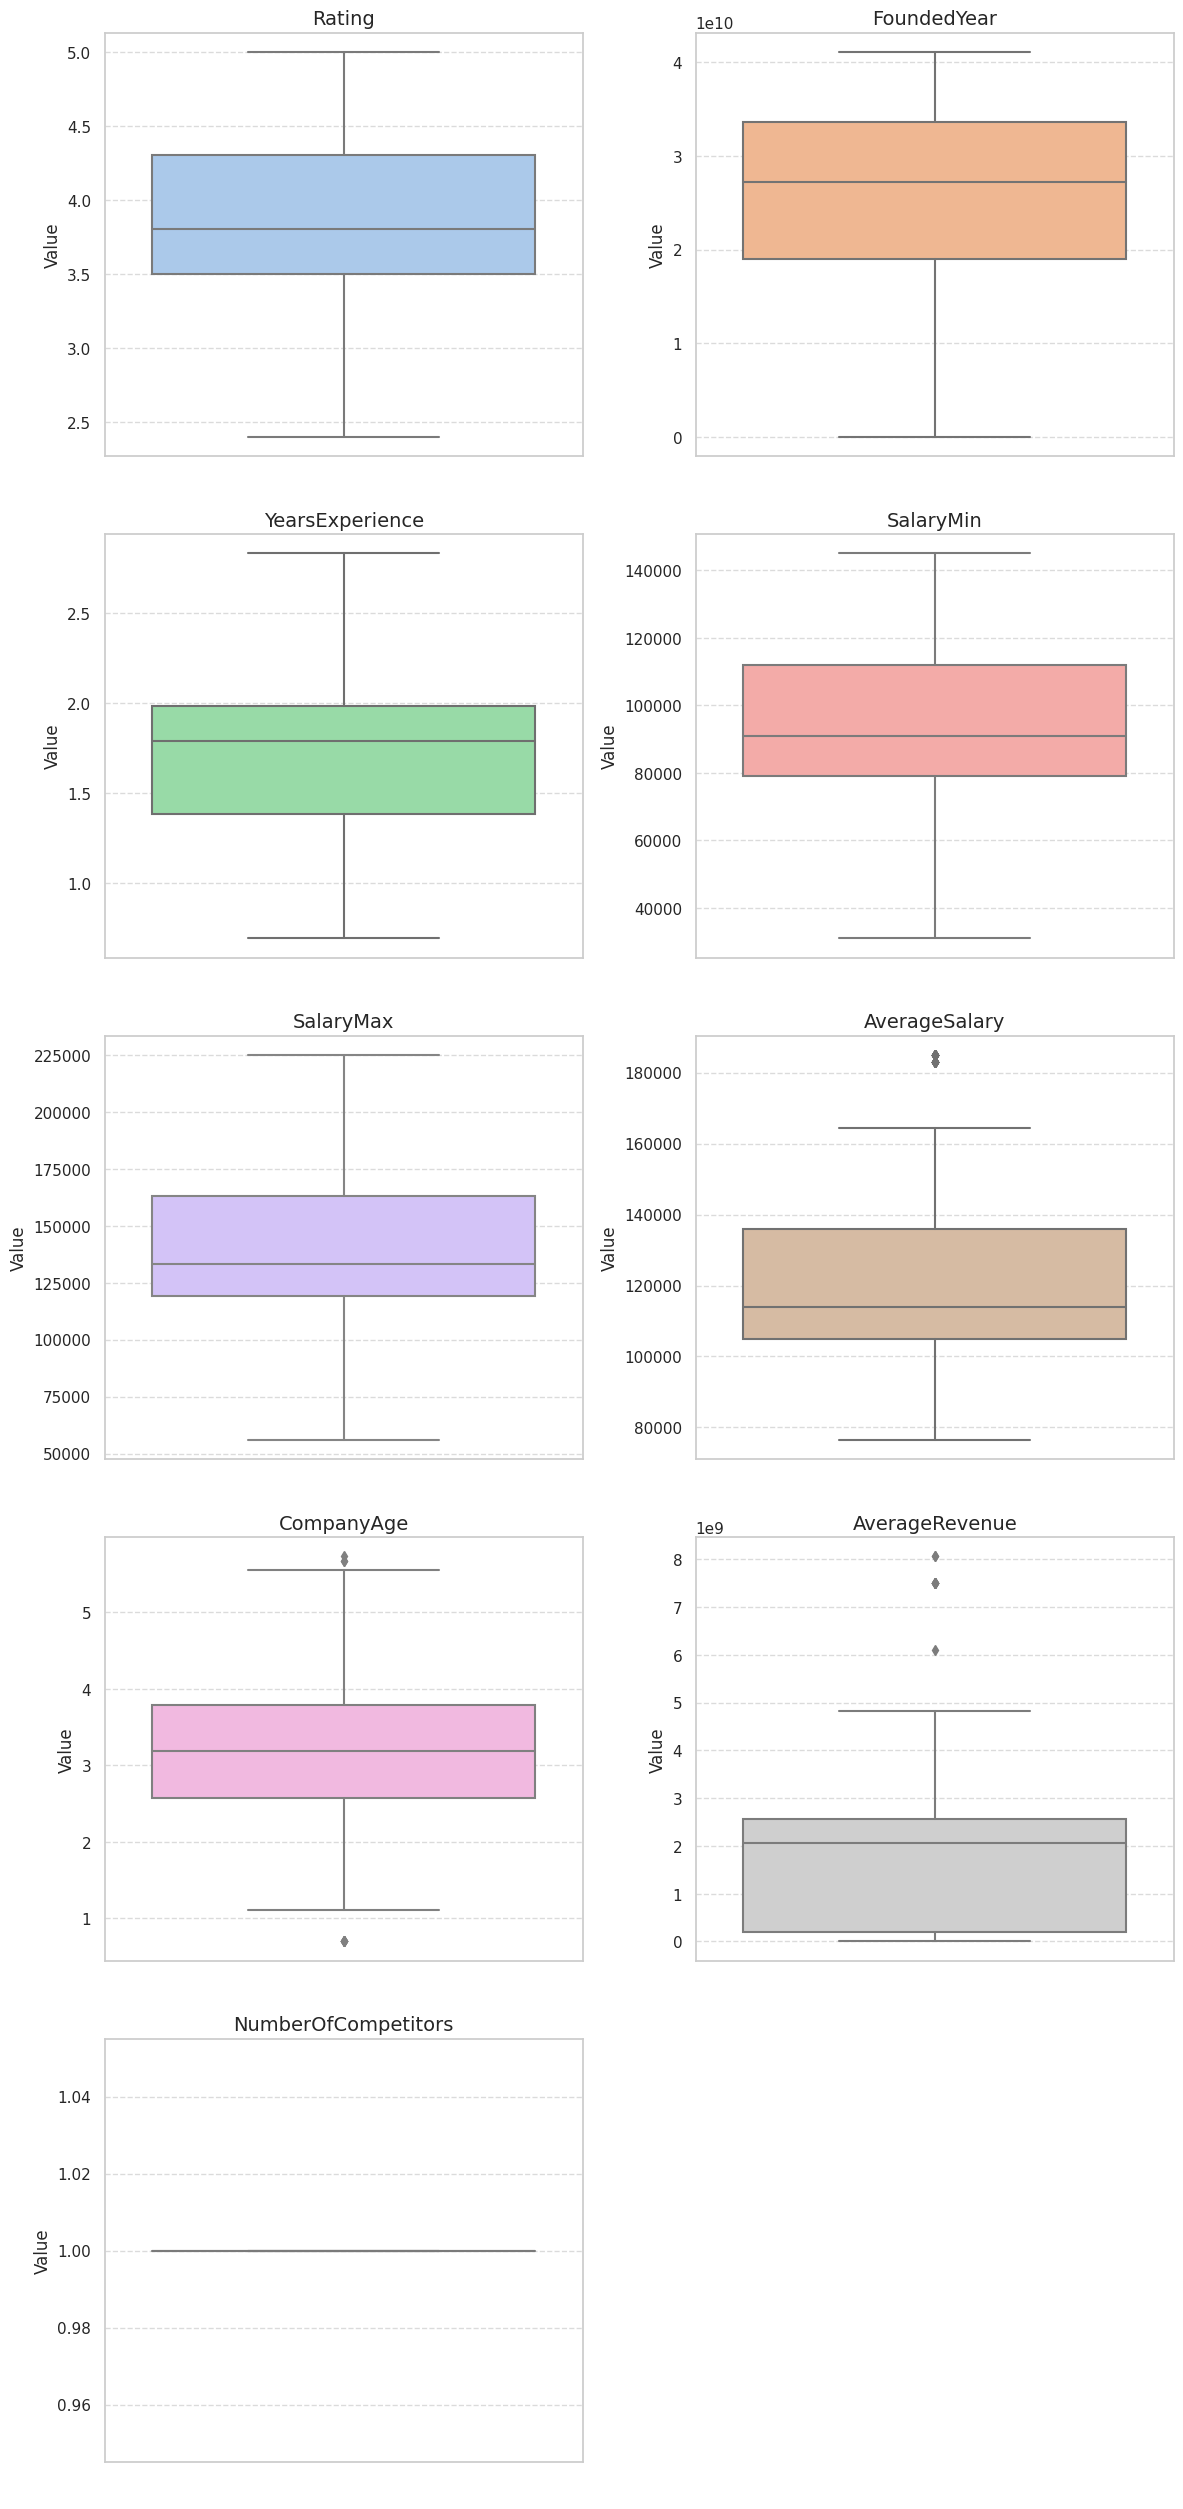

In [99]:
# Let's verify
# Select the numeric col
numeric_col = df.select_dtypes(include='number')
# Set the number of rows and columns for subplots
num_cols = len(df.columns)
num_rows = (num_cols + 1) // 2  # Two plots per row

# Create a figure for the subplots
plt.figure(figsize=(12, num_rows * 5))

# Loop through each column and create a boxplot
for i, column in enumerate(numeric_col.columns):
    plt.subplot(num_rows, 2, i + 1)  # Adjust the subplot grid as needed
    sns.boxplot(y=df[column], color=sns.color_palette("pastel")[i % 8])  # Use pastel colors
    plt.title(column, fontsize=14)
    plt.ylabel('Value', fontsize=12)
    plt.xlabel(' ', fontsize=12)  # Label for the x-axis (empty for aesthetics)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

In [100]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['SalaryMin', 'SalaryMax', 'AverageRevenue']] = scaler.fit_transform(df[['SalaryMin', 'SalaryMax', 'AverageRevenue']])

In [101]:
df.sample(10)

JobTitle SalaryEstimate  Rating                    CompanyName  \
503  data scientist         95-119     4.0       Two95 International Inc.   
389  data scientist        110-163     3.8                         HireAi   
8    data scientist        137-171     4.4                  Intuit - Data   
160  data scientist        101-165     4.5                     Demandbase   
435  data scientist         79-133     5.0                      PeopleCom   
336  data scientist         79-147     3.3  The Davey Tree Expert Company   
224  data scientist         71-123     3.6                       Opendoor   
546  data scientist         66-112     4.6           HAN IT Staffing Inc.   
45              mle         75-131     4.1                         Pfizer   
269   data engineer         91-150     5.0                          Paige   

    CompanySize   FoundedYear  OwnershipType  \
503        1-50  2.717181e+10        Private   
389     Unknown  2.717181e+10        Private   
8    5001-10000  1.895429e+10         Public   
160     201-500  3.154902e+10        Private   
435        1-50  2.717181e+10        Private   
336     10000++  6.576008e+08  Self-employed   
224    501-1000  3.721378e+10        Private   
546      51-200  3.572785e+10        Private   
45      10000++  1.129657e+08         Public   
269        1-50  4.033187e+10        Private   

                                    Industry                     Sector  \
503                   Staffing & Outsourcing          Business Services   
389                Biotech & Pharmaceuticals     Information Technology   
8               Computer Hardware & Software     Information Technology   
160             Computer Hardware & Software     Information Technology   
435                Biotech & Pharmaceuticals     Information Technology   
336                        Timber Operations     Agriculture & Forestry   
224                              Real Estate                Real Estate   
546                              It Services     Information Technology   
45                 Biotech & Pharmaceuticals  Biotech & Pharmaceuticals   
269  Enterprise Software & Network Solutions     Information Technology   

                  RequiredSkills  ... SalaryMax  AverageSalary  State  \
503      [Python, R, SQL, Scala]  ... -0.653282       107000.0     IL   
389  [Python, R, SQL, Java, C++]  ...  0.601867       136500.0     CA   
8                            [R]  ...  0.830076       154000.0     CA   
160             [Python, R, SQL]  ...  0.658919       133000.0     CA   
435             [Python, R, SQL]  ... -0.253917       106000.0     VA   
336      [Python, R, SQL, Scala]  ...  0.145449       113000.0     OH   
224             [Python, R, SQL]  ... -0.539178        97000.0     CA   
546             [Python, R, SQL]  ... -0.852965        89000.0     NY   
45                   [Python, R]  ... -0.310969       103000.0     MA   
269      [Python, R, SQL, Scala]  ...  0.231027       120500.0     NY   

              City  CompanyAge AverageRevenue NumberOfCompetitors  \
503        Chicago    3.182898      -1.026335                 1.0   
389  San Francisco    3.182898       1.386214                 1.0   
8        San Diego    3.806654       1.019170                 1.0   
160  San Francisco    2.742618      -0.852611                 1.0   
435         McLean    3.182898      -1.026335                 1.0   
336           Kent    5.313074      -0.150693                 1.0   
224  San Francisco    1.839103       1.019170                 1.0   
546       New York    2.143388       0.243410                 1.0   
45       Cambridge    5.544569       0.176869                 1.0   
269       New York    0.700157       1.639197                 1.0   

     ExperienceLevel  SalaryCategory              RevComp  
503        Mid-level          Medium          3000000.0_1  
389        Mid-level          Medium       4127500000.0_1  
8          Mid-level          Medium       3500000000.0_3  
160 

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 668 entries, 0 to 671
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   JobTitle             668 non-null    object  
 1   SalaryEstimate       668 non-null    object  
 2   Rating               668 non-null    float64 
 3   CompanyName          668 non-null    category
 4   CompanySize          668 non-null    object  
 5   FoundedYear          668 non-null    float64 
 6   OwnershipType        668 non-null    category
 7   Industry             668 non-null    category
 8   Sector               668 non-null    category
 9   RequiredSkills       668 non-null    object  
 10  EducationLevel       668 non-null    object  
 11  YearsExperience      668 non-null    float64 
 12  SalaryMin            668 non-null    float64 
 13  SalaryMax            668 non-null    float64 
 14  AverageSalary        668 non-null    float64 
 15  State                668 non